## Import Libraries

In [1]:
! pip install optuna

In [100]:
import numpy as np
import pandas as pd
import os
import json
import zipfile
import gc
import matplotlib.pylab as plt
import seaborn as sns
import warnings 
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
sns.set_style("whitegrid")
from tqdm import tqdm
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
import pickle
from prettytable import PrettyTable
import prettytable
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from IPython.display import Image
import optuna
optuna.logging.set_verbosity(20)
import lightgbm
import pickle
import xgboost as xgb
from IPython.display import Image
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint

master_path = '/content/drive/MyDrive/Elo_kaggle/'
path = 'C:/Users/praveen.jalaja/Desktop/MachineLearning/Applied-AI.githib.io/ML Case Study/'


## Loading Functions

In [5]:
## Reference: https://www.kaggle.com/c/champs-scalar-coupling/discussion/96655

def reduce_memory_usage(df, verbose=True):
  '''
  This function reduces the memory sizes of datafram by changing the dattypes of the columns.
  Parameters
  df - DataFrame whose size to be reduced
  verbose - Boolean, to mention the verbose required or not.
  '''
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)
          else:
              c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)
  end_mem = df.memory_usage().sum() / 1024**2
  if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
  return df

In [6]:
def aggregated_features(new_df, df, aggs, grpby, name='',  prefix='', use_col=False):
  '''
  This function is to find the 
  aggregated values (min,max,mean,sum,nunique,std) for a columns aggregated by the groupby operation
  
  Parameters:
  new_df   - features will be added to this DF
  df       - original DF from which the features will be created
  grpby    - based on this column we'll to group by
  name     - name for the new features created
  aggs     - dictionary contains key as the column the operation performed and list of operations as the value.
  prefix   - added to the name of the feature -- default value empty
  use_col  - if set True then the original column name will be uesd to name the new feature -- default value False
  '''
  ## boolean for using the original column name in the aggregated features
  ## iterating through the columns of the need to be aggregated 

  for col, funcs in tqdm(aggs.items()):
    for func in funcs:
        # Getting the name of aggregation function
        if isinstance(func, str):
            func_str = func
        else:
            func_str = func.__name__ 
        # create the column
        if use_col:
          name = prefix+'_'+col+'_'+'{}'.format(func_str)

        new_df[name] = df.groupby([grpby])[col].agg(func).values

  return new_df 


In [7]:
def label_encoder(df, cols):
  '''
  This Function label encode the values in the specified columns and 
  return the data frame
  Parameters:
  df   - Original DataFrame
  cols - label encode the specified columns
  '''
  lbl_enc = LabelEncoder()
  for col in cols:
    df[col] = lbl_enc.fit_transform(df[col].astype(str))
  return df

## Downloading Data

setting up the api token to download all the kaggle dataset.

In [4]:
## creating a dictionary with username and key
api_token = {"username":"praveenjalaja","key":"254009cd9fcebc728fb2b82a4f00d301"}
!mkdir -p ~/.kaggle
## new json created for download the data 
with open('kaggle.json', 'w') as file:
    json.dump(api_token, file)
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [5]:
## download the neccesary data
!kaggle competitions download -c elo-merchant-category-recommendation

  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 99.1MB/s]
  0% 0.00/846k [00:00<?, ?B/s]
100% 846k/846k [00:00<00:00, 196MB/s]
  0% 0.00/17.2k [00:00<?, ?B/s]
100% 17.2k/17.2k [00:00<00:00, 12.7MB/s]
 79% 39.0M/49.4M [00:00<00:00, 68.4MB/s]
100% 49.4M/49.4M [00:00<00:00, 142MB/s] 
  0% 0.00/1.13M [00:00<?, ?B/s]
100% 1.13M/1.13M [00:00<00:00, 153MB/s]
 95% 12.0M/12.7M [00:00<00:00, 125MB/s]
100% 12.7M/12.7M [00:00<00:00, 116MB/s]
 99% 541M/548M [00:02<00:00, 212MB/s]
100% 548M/548M [00:02<00:00, 198MB/s]
  0% 0.00/17.2k [00:00<?, ?B/s]
100% 17.2k/17.2k [00:00<00:00, 14.6MB/s]


In [4]:
## unzipping the transacations
! unzip /content/historical_transactions.csv.zip
!rm /content/historical_transactions.csv.zip
! unzip /content/new_merchant_transactions.csv.zip
!rm /content/new_merchant_transactions.csv.zip
! unzip /content/merchants.csv.zip
!rm /content/merchants.csv.zip
! unzip /content/train.csv.zip
!rm /content/train.csv.zip
! unzip /content/test.csv.zip
!rm /content/test.csv.zip
! unzip /content/sample_submission.csv.zip
!rm /content/sample_submission.csv.zip

Archive:  /content/historical_transactions.csv.zip
  inflating: historical_transactions.csv  
Archive:  /content/new_merchant_transactions.csv.zip
  inflating: new_merchant_transactions.csv  
Archive:  /content/merchants.csv.zip
  inflating: merchants.csv           
Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


##Loading Data

In [14]:
train                     = pd.read_csv('/content/train.csv', parse_dates=["first_active_month"])
sample                    = pd.read_csv('/content/sample_submission.csv')
test                      = pd.read_csv('/content/test.csv', parse_dates=["first_active_month"])
historical_transactions   = pd.read_csv('/content/historical_transactions.csv',parse_dates=['purchase_date'])
merchants                 = pd.read_csv('/content/merchants.csv')
new_merchant_transactions = pd.read_csv('/content/new_merchant_transactions.csv',parse_dates=["purchase_date"])

Upon Loading these csv the memory usage in the colab notebooks/kernel is increased. This increase memory usage may results in the RAM crashing in Later operations. To reduce the memory usage the below function used. It does the following:
  - Load objects as categories
  - Binary values are switched to int8
  - Binary values with missing values are switched to float16
  - 64 bits encoding are all switched to 32 or 16bits if possible.


reduction of memory usage in files

In [15]:
train                     = reduce_memory_usage(train)
test                      = reduce_memory_usage(test)
historical_transactions   = reduce_memory_usage(historical_transactions)
merchants                 = reduce_memory_usage(merchants)
new_merchant_transactions = reduce_memory_usage(new_merchant_transactions)

Mem. usage decreased to  5.20 Mb (43.7% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 2026.75 Mb (34.8% reduction)
Mem. usage decreased to 39.90 Mb (29.0% reduction)
Mem. usage decreased to 136.66 Mb (34.8% reduction)


Another important step before jumping into the Exploration of the data. The train.csv file only has the target value, which is the feature we are gonna predict with models build in the future. 

But, transactions data don't have the target values in it for each card_id's. By merging the "target" feature with the transactions data will help in Data analysis to fully understand different fetures in transactional dataFrame. 

In [17]:
## merging target value of card_id for each transction in historical_transactions Data
historical_transactions = pd.merge(historical_transactions, train[['card_id','target']], how = 'outer', on = 'card_id')

## merging target value of card_id for each transction in new_merchants_transactions Data
new_merchant_transactions = pd.merge(new_merchant_transactions, train[['card_id','target']], how = 'outer', on = 'card_id')

## Exploring train.csv and test.csv 

In [ ]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,186538,5,2,1,-0.820283
1,2017-01,77733,4,1,0,0.392913
2,2016-08,272262,2,2,0,0.688056
3,2017-09,30930,4,3,0,0.142495
4,2017-11,261467,1,3,0,-0.159749


In [ ]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,13622,3,3,1
1,2017-01,24152,2,3,0
2,2017-08,232780,5,1,1
3,2017-12,267536,2,1,0
4,2015-12,55228,5,1,1


Let's check whether there any card_id's both in train and test data

In [ ]:
len(pd.merge(train,test, on = 'card_id'))

0

There are no card_id's present in both train and test data.

Converting the date string into datetime datatype

Check for nan values in the whole train and test data

In [ ]:
train['first_active_month'] = pd.to_datetime(train['first_active_month'],
                                             format='%Y-%m')
test['first_active_month'] = pd.to_datetime(test['first_active_month'],
                                             format='%Y-%m')

In [ ]:
train.isna().any()

first_active_month    False
card_id               False
feature_1             False
feature_2             False
feature_3             False
target                False
dtype: bool

In train Data there is no nan values of any features in train data

In [ ]:
test.isna().any()

first_active_month     True
card_id               False
feature_1             False
feature_2             False
feature_3             False
dtype: bool

In [ ]:
test[test['first_active_month'].isna()]

,first_active_month,card_id,feature_1,feature_2,feature_3
11578,NaT,247334,5,2,1


In the Test Data, there is one row with 'first_active_month' as nan value. Since it is test data we have to impute the value.

In this kernel, the nan value is imputed with value of mode.

In [ ]:
test.fillna(value = test['first_active_month'].value_counts().idxmax(), axis = 1, inplace=True )

In [ ]:
test.isna().any().any()

False

In [ ]:
test.to_csv(master_path+'test_fill_na.csv', index=False)

#### pdf of the Target variable 

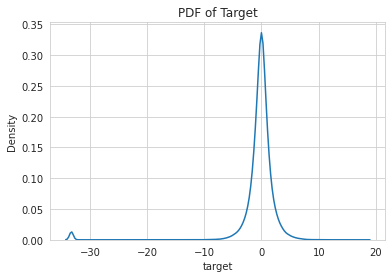

In [ ]:
sns.kdeplot(train['target'])
plt.title("PDF of Target")
plt.show()

Observation: The target value is almost normally distributed with bunch of outlier value near -30. **This distribution indicates that the target value is normalized with pre-decided mean and standard deviation**

 This outlier value of the target is a value which needs more look into the feature EDA to understand cause of it.

#### bar Plot of the anonymized features (feature_1,feature_2,feature_3) in train data


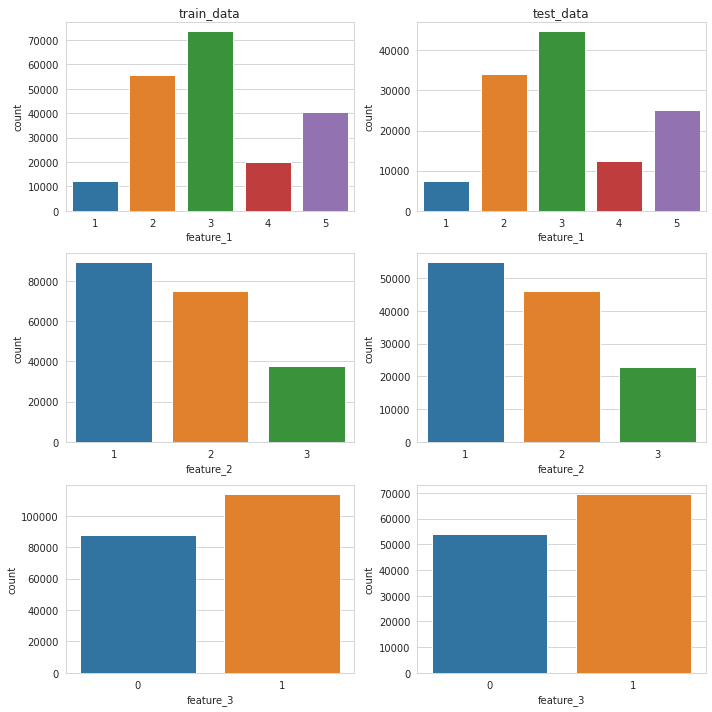

In [ ]:
cols = ["train_data", "test_data"]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

sns.countplot(x='feature_1', data=train,ax= axes[0,0])
sns.countplot(x='feature_2', data=train,ax= axes[1,0])
sns.countplot(x='feature_3', data=train,ax= axes[2,0])
sns.countplot(x='feature_1', data=test,ax= axes[0,1])
sns.countplot(x='feature_2', data=test,ax= axes[1,1])
sns.countplot(x='feature_3', data=test,ax= axes[2,1])

fig.tight_layout()
plt.show()

The categories of the feature_1,feature_2,feature_3 in train and test data are distributed in the same way in each features. This give us a proof that these three features helps us to reduce the risk of the overfitting. And, it assures the distribution of train and test data doesn't differ, by giving confidence results. 


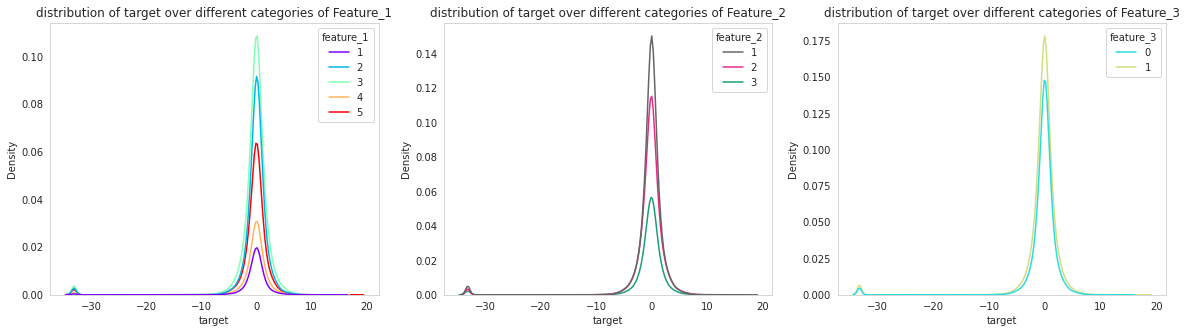

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(131)
sns.kdeplot(x ='target',data = train,hue = 'feature_1',palette='rainbow')
plt.title('distribution of target over different categories of Feature_1')
plt.grid()
plt.subplot(132)
sns.kdeplot(x ='target',data = train,hue = 'feature_2',palette='Dark2_r')
plt.title('distribution of target over different categories of Feature_2')
plt.grid()
plt.subplot(133)
sns.kdeplot(x ='target',data = train,hue = 'feature_3',palette='rainbow')
plt.title('distribution of target over different categories of Feature_3')
plt.grid()
plt.show()

The disribution of the target with respect to the categroies of feature doesn't differ from each other. This shows the target values are not skewed for different categories in these three anonymized features. we have to check the feature importance of these features while feature selection

#### First_active_month Vs Target variable

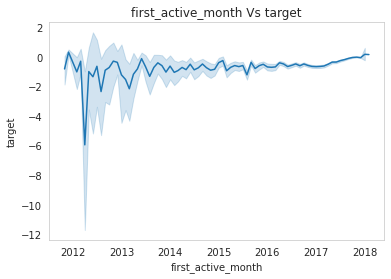

In [ ]:
sns.lineplot(x = train['first_active_month'], y= train['target'])
plt.title("first_active_month Vs target")
plt.grid()
plt.show()

The above plot reveals that the target variable (loyalty score) behaves like a damping frequency plot. And it is mentioned in the Buisness problem that the target score is calcuated with the recent year transactions. 

Older Card's: The cards which have first active month from 2012 to 2015.

new card's: The cards which have first active month from 2015 to 2018.

The Older card's have large number of transactions which affects the target towards the negative value. and the new card's have transactions which affects the target towards positive value.

So, I think the type of transactions by the newer card's is different from the older card's which helps in increase the loyalty Score.

#### Correlation between the features in train

In [18]:
cols = ['feature_1','feature_2','feature_3']

n = train[cols]

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(n.iloc[:,:].values, i) for i in range(n.shape[1])]
vif["features"] = n.columns
vif

,VIF Factor,features
0,0.000327,feature_1
1,0.000158,feature_2
2,0.000653,feature_3


The VIF values for all the three features are well under 10. So there is no problem of multicollinearity in the train data.

## Exploring Merchants Data

In [ ]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


Check for nan values


In [ ]:
merchants.isna().any()

merchant_id                    False
merchant_group_id              False
merchant_category_id           False
subsector_id                   False
numerical_1                    False
numerical_2                    False
category_1                     False
most_recent_sales_range        False
most_recent_purchases_range    False
avg_sales_lag3                  True
avg_purchases_lag3             False
active_months_lag3             False
avg_sales_lag6                  True
avg_purchases_lag6             False
active_months_lag6             False
avg_sales_lag12                 True
avg_purchases_lag12            False
active_months_lag12            False
category_4                     False
city_id                        False
state_id                       False
category_2                      True
dtype: bool

In [ ]:
merchants.columns[merchants.isna().any()]

Index(['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12', 'category_2'], dtype='object')

There are nan values in four features 'avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12', 'category_2'.

Let's dig into these three features to understand the features and decide on the imputation

In [ ]:
merchants[merchants['avg_sales_lag3'].isna()].index

Int64Index([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64')

In [ ]:
A = merchants[merchants['avg_sales_lag3'].isna()].index
B = merchants[merchants['avg_sales_lag6'].isna()].index
C = merchants[merchants['avg_sales_lag12'].isna()].index

np.logical_and( (A==B).all(), (B==C).all() )

True

NaN values in the three features of average sales are of same rows or merchant_id's. 

In [ ]:
na_merchant_id =merchants[merchants['avg_sales_lag3'].isna()]['merchant_id']

In [ ]:
hist_nan_merchants = historical_transactions[historical_transactions['merchant_id'].isin(na_merchant_id)]
hist_nan_merchants.shape

(0, 16)

In [ ]:
new_nan_merchants= new_merchant_transactions[new_merchant_transactions['merchant_id'].isin(na_merchant_id)]
new_nan_merchants.shape

(0, 16)

In [ ]:
print("Percentage of historicaltransactions with NaN average sales merchants",
      (hist_nan_merchants.shape[0]/historical_transactions.shape[0])*100)

Percentage of historicaltransactions with NaN average sales merchants 0.0


In [ ]:
print("Percentage of new transactions with NaN average sales merchants",
      (new_nan_merchants.shape[0]/new_merchant_transactions.shape[0])*100)

Percentage of new transactions with NaN average sales merchants 0.0


In total, these merchants have almost have more than 10,000 rows of transactions but compare to the total number of rows, these merchants are trivial number of 0.05 % total number of transactions in both historical and new transactions.

So we remove all the transactions with these merchants with nan average sales are removed


we can remove these rows if they have less number of transactions in the transactions data

In [ ]:
## droping rows with nan values in these three features
merchants.dropna(subset=['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12'],inplace = True)
## removing transactions from these merchants in both historical and new transactions
historical_transactions.drop(index = hist_nan_merchants.index, axis = 0, inplace = True)
new_merchant_transactions.drop(index = new_nan_merchants.index, axis = 0, inplace = True)

In [ ]:
print("The Percentage of merchants with nan values in Category_2 feature",
(merchants[merchants['category_2'].isna()].shape[0]/merchants.shape[0])*100)

The Percentage of merchants with nan values in Category_2 feature 3.549926348216073


In [ ]:
print("Unique values in category_1",merchants['category_1'].unique())
print("Unique values in category_2",merchants['category_2'].unique())
print("Unique values in category_4",merchants['category_4'].unique())

Unique values in category_1 ['N' 'Y']
Unique values in category_2 [ 1.  5.  2.  3.  4. nan]
Unique values in category_4 ['N' 'Y']


Since 3% of merchants have nan values in category_2 feature. And it is a categorical feature. 

The 'category_2' feature nan values are considered as an another category '0'.


In [ ]:
## filling all nan values in category_2 feature with the value 0
merchants['category_2'] = merchants['category_2'].fillna(value = 0.)

In [ ]:
merchants.isna().any().any()

False

No Nan values in the whole merchants data

#### Bar Plot of the three anonymized caregory features(category_1,category_2,category_4)


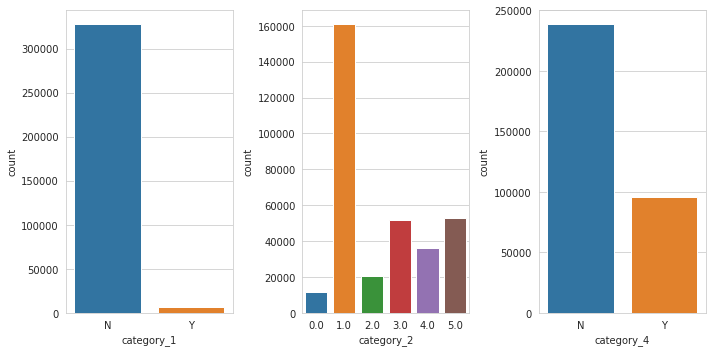

In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(131)
sns.countplot(x= 'category_1', data = merchants)
plt.subplot(132)
sns.countplot(x= 'category_2', data = merchants)
plt.subplot(133)
sns.countplot(x= 'category_4', data = merchants)
plt.tight_layout()
plt.show()

These are anonyms categories, which can represent some properties of the merchants, which is still unclear after merging with the transactions data it can reveal more info.

#### Distribution of Numerical features 

In [ ]:
import prettytable
from prettytable import PrettyTable
def IQR(x):
  y = PrettyTable()
  y.hrules = prettytable.ALL
  quantiles = ['25%','50%','75%','100%']
  values = [x.quantile(0.25),x.quantile(0.50),x.quantile(0.75),x.quantile(1)]
  y.add_column("Quantiles ",quantiles)
  y.add_column("Values", values)
  print(y)

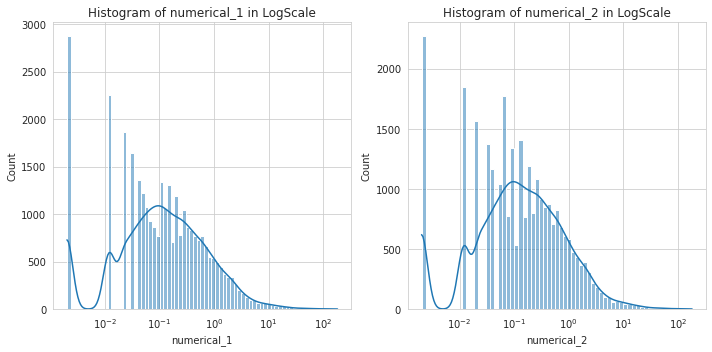

In [ ]:
plt.figure(figsize=(10,5) )
plt.subplot(121)
sns.histplot(merchants['numerical_1'], log_scale=True,kde=True)
plt.title("Histogram of numerical_1 in LogScale")
plt.subplot(122)
sns.histplot(merchants['numerical_2'], log_scale=True,kde=True)
plt.title("Histogram of numerical_2 in LogScale")
plt.tight_layout()
plt.show()

In [ ]:
 merchants[['numerical_1','numerical_2']].describe()

,numerical_1,numerical_2
count,334683.000000,334683.000000
mean,0.011479,0.008106
std,1.098175,1.070518
min,-0.057471,-0.057471
25%,-0.057471,-0.057471
50%,-0.057471,-0.057471
75%,-0.047556,-0.047556
max,183.735111,182.079322


The Distribution of numerical_1 and numerical_2 featurs are almost identical three qunatiles have identical values. These two features may be a duplicate of each other with added noise. 

The numerical_1 and numerical_2 features are checked for feature importance in an aggregated fashion.


#### Distribution of Sales Averages

In [ ]:
merchants.columns

Index(['merchant_id', 'merchant_group_id', 'merchant_category_id',
       'subsector_id', 'numerical_1', 'numerical_2', 'category_1',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4', 'city_id', 'state_id', 'category_2'],
      dtype='object')

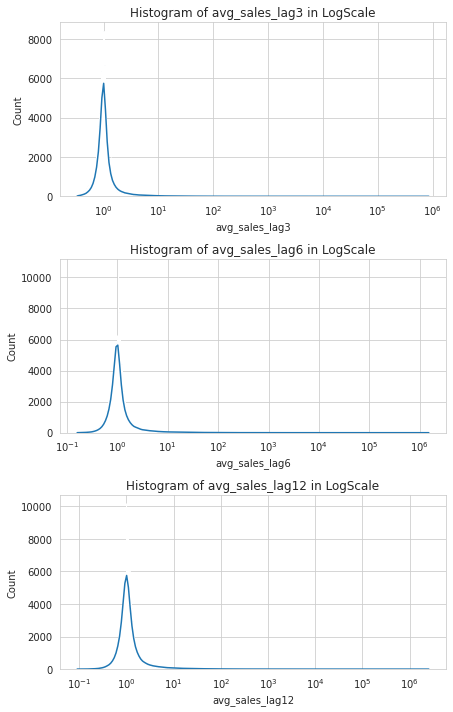

In [ ]:
plt.figure(figsize=(6.4,10))
plt.subplot(311)
sns.histplot(merchants['avg_sales_lag3'], log_scale=True,kde=True)
plt.title("Histogram of avg_sales_lag3 in LogScale")
plt.subplot(312)
sns.histplot(merchants['avg_sales_lag6'], log_scale=True,kde=True)
plt.title("Histogram of avg_sales_lag6 in LogScale")
plt.subplot(313)
sns.histplot(merchants['avg_sales_lag12'], log_scale=True,kde=True)
plt.title("Histogram of avg_sales_lag12 in LogScale")
plt.tight_layout()
plt.show()

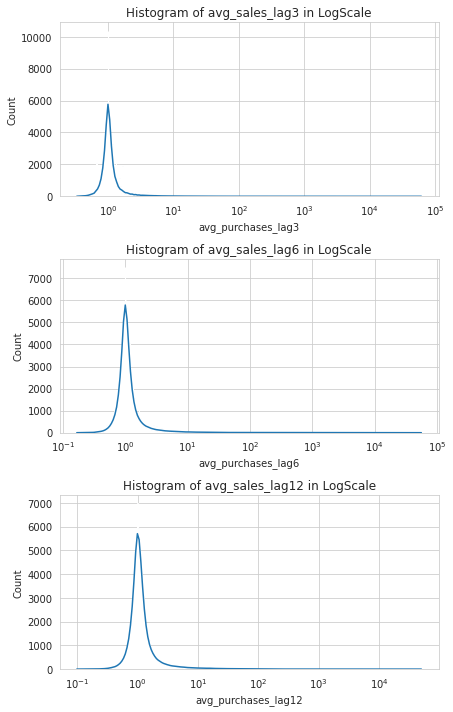

In [ ]:
plt.figure(figsize=(6.4,10))
plt.subplot(311)
sns.histplot(merchants['avg_purchases_lag3'], log_scale=True,kde=True)
plt.title("Histogram of avg_sales_lag3 in LogScale")
plt.subplot(312)
sns.histplot(merchants['avg_purchases_lag6'], log_scale=True,kde=True)
plt.title("Histogram of avg_sales_lag6 in LogScale")
plt.subplot(313)
sns.histplot(merchants['avg_purchases_lag12'], log_scale=True,kde=True)
plt.title("Histogram of avg_sales_lag12 in LogScale")
plt.tight_layout()
plt.show()

The average purchases and sales across 3,6 and 12 months are fractions. So, it is distributed near 0.

And, there are outliers in all the average sales and purchases. These features gives info about the merchants but not about the card_id's. The information about the merchants have to cumulated for each card_id's.

#### most_recent_sales_range and most_recent_purchases_range

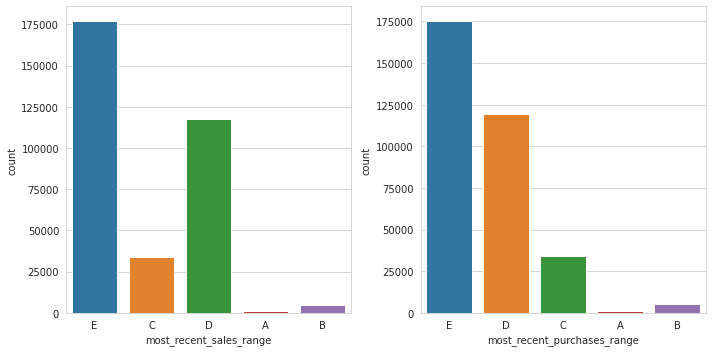

In [ ]:

plt.figure(figsize = (10,5))
plt.subplot(121)
sns.countplot(x= 'most_recent_sales_range', data = merchants)
plt.subplot(122)
sns.countplot(x= 'most_recent_purchases_range', data = merchants)
plt.tight_layout()
plt.show()

The sales range in last active month is a categorical feature with "A","B","C","D","E".Range of revenue (monetary units) in last active month is in order A > B > C > D > E. 

The Bar Plot shows there are many merchants with revenue range of "E" than other ranges. 

And also, Bar Plot shows there are many merchants with purchase quantity range of "E" than other ranges. 

 The sales range and purchase range can be used in aggregated to know the card_id's most visited merchants in the final features for training.

#### Quantity of active months

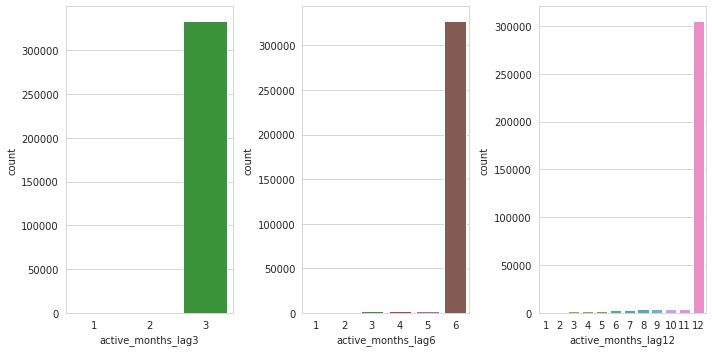

In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(131)
sns.countplot(x= 'active_months_lag3', data = merchants)
plt.subplot(132)
sns.countplot(x= 'active_months_lag6', data = merchants)
plt.subplot(133)
sns.countplot(x= 'active_months_lag12', data = merchants)
plt.tight_layout()
plt.show()

This active months represents doesn't provide any information about the cards. These features are greatly skewed. So it should be removed from the final training data.

#### Correlation between variables

##### Variance Inflation Factor

In [19]:
cols = ['active_months_lag3','active_months_lag6','active_months_lag12','numerical_1', 'numerical_2','avg_sales_lag3','avg_sales_lag6','avg_purchases_lag3','avg_sales_lag12','avg_purchases_lag12','avg_purchases_lag6','category_2','state_id']
merchi = merchants[cols]
merchi = merchi.dropna()

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(merchi.iloc[:,:].values, i) for i in range(merchi.shape[1])]
vif["features"] = merchi.columns
vif

,VIF Factor,features
0,517.963456,active_months_lag3
1,888.058020,active_months_lag6
2,148.780439,active_months_lag12
3,399.578768,numerical_1
4,399.554974,numerical_2
5,45.881736,avg_sales_lag3
6,252.021717,avg_sales_lag6
7,398.529758,avg_purchases_lag3
8,130.293238,avg_sales_lag12
9,580.462034,avg_purchases_lag12


Looks like there are variables which are heavily correlated like active_months_lag6, numerical_1 and 2, avg_purchase_lag6 and avg_sales_lag_6 and avg_purchase_lag12

Let's remove some of the variables and again we'll calculate the VIF

In [20]:
cols = ['active_months_lag3','active_months_lag12','numerical_1', 'avg_sales_lag3','avg_purchases_lag3','avg_sales_lag12','avg_purchases_lag12','category_2','state_id']
merchi = merchants[cols]
merchi = merchi.dropna()

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(merchi.iloc[:,:].values, i) for i in range(merchi.shape[1])]
vif["features"] = merchi.columns
vif

,VIF Factor,features
0,77.199414,active_months_lag3
1,70.037085,active_months_lag12
2,1.000416,numerical_1
3,2.756102,avg_sales_lag3
4,79.868728,avg_purchases_lag3
5,1.801982,avg_sales_lag12
6,78.972876,avg_purchases_lag12
7,3.326589,category_2
8,5.576621,state_id


As we can see that after removing some of the correlated variables we can see that VIF score reduces significantly.

However there are still values which are above 10. However it is less than 100. So instead of removing them straightaway it needs further investigation.

Let's plot the correlation matrix

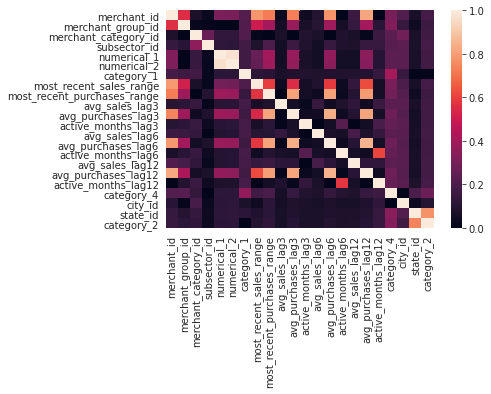

In [22]:
corr = merchants.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
corr_norm=np.round((corr-corr.min())/(corr.max()-corr.min()), 3)
sns.heatmap(corr_norm, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=False)

As we seen before as the numerical_1 and numerical_2 have similar values and 
distributions and they are correlated

The state_id is correlated with city_id and category_2. Since the anonymized feature category_2 is correlated with state_id I think it is somehow related to location.

There are notable correlations between purchase lags and month lags

merchant_id is correlated with merchant_group_id






## Exploring historical transactions and new merchant transactions

In [ ]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,target,hist_or_new
0,Y,99809,88,N,0,A,80,292909.0,8,-0.703331,2017-06-25 15:33:07,1.00000000,16,37,NaN,0
1,Y,99809,88,N,0,A,367,176215.0,7,-0.733128,2017-07-15 12:10:45,1.00000000,16,16,NaN,0
2,Y,99809,88,N,0,A,80,198284.0,6,-0.720386,2017-08-09 22:04:29,1.00000000,16,37,NaN,0
3,Y,99809,88,N,0,A,560,301747.0,5,-0.735352,2017-09-02 10:06:26,1.00000000,16,34,NaN,0
4,Y,99809,88,N,0,A,80,292909.0,11,-0.722865,2017-03-10 01:14:19,1.00000000,16,37,NaN,0


In [ ]:
new_merchant_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,target,hist_or_new
0,Y,83272,107.0,N,1.0,B,307.0,230937.0,1.0,-0.557574,2018-03-11 14:57:36,1.00000000,9.0,19.0,NaN,1
1,Y,83272,140.0,N,1.0,B,307.0,178440.0,1.0,-0.569580,2018-03-19 18:53:37,1.00000000,9.0,19.0,NaN,1
2,Y,83272,330.0,N,1.0,B,507.0,226430.0,2.0,-0.551037,2018-04-26 14:08:44,1.00000000,9.0,14.0,NaN,1
3,Y,83272,-1.0,Y,1.0,B,661.0,207191.0,1.0,-0.671925,2018-03-07 09:43:21,NaN,-1.0,8.0,NaN,1
4,Y,304258,-1.0,Y,1.0,B,166.0,78977.0,1.0,-0.659904,2018-03-22 21:07:53,NaN,-1.0,29.0,-4.839243,1


convert purchase date to datetime format

In [ ]:
historical_transactions['purchase_date'] = pd.to_datetime(historical_transactions['purchase_date'],
                                             format='%Y-%m-%d %H:%M:%S')

In [ ]:
new_merchant_transactions['purchase_date'] = pd.to_datetime(historical_transactions['purchase_date'],
                                             format='%Y-%m-%d %H:%M:%S')

check for the nan values

In [ ]:
historical_transactions.isna().any()

authorized_flag         False
card_id                 False
city_id                 False
category_1              False
installments            False
category_3               True
merchant_category_id    False
merchant_id              True
month_lag               False
purchase_amount         False
purchase_date           False
category_2               True
state_id                False
subsector_id            False
target                   True
hist_or_new             False
dtype: bool

In [ ]:
new_merchant_transactions.isna().any()

authorized_flag          True
card_id                 False
city_id                  True
category_1               True
installments             True
category_3               True
merchant_category_id     True
merchant_id              True
month_lag                True
purchase_amount          True
purchase_date           False
category_2               True
state_id                 True
subsector_id             True
target                   True
hist_or_new             False
dtype: bool

In [ ]:
historical_transactions.columns[historical_transactions.isna().any()]

Index(['category_3', 'merchant_id', 'category_2', 'target'], dtype='object')

In [ ]:
new_merchant_transactions.columns[new_merchant_transactions.isna().any()]

Index(['authorized_flag', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'category_2', 'state_id', 'subsector_id', 'target'],
      dtype='object')

In [ ]:
print("The Percentage of historical_transactions with nan values in Category_2 feature",
(historical_transactions[historical_transactions['category_2'].isna()].shape[0]/historical_transactions.shape[0])*100)

print("The Percentage of new_merchant_transactions with nan values in Category_3 feature",
(new_merchant_transactions[new_merchant_transactions['category_3'].isna()].shape[0]/new_merchant_transactions.shape[0])*100)

The Percentage of historical_transactions with nan values in Category_2 feature 9.1125003568072
The Percentage of new_merchant_transactions with nan values in Category_3 feature 3.9221405749832994


In [ ]:
print("The Percentage of historical_transactions with nan values in merchant_id feature",
(historical_transactions[historical_transactions['merchant_id'].isna()].shape[0]/historical_transactions.shape[0])*100)

print("The Percentage of new_merchant_transactions with nan values in merchant_id feature",
(new_merchant_transactions[new_merchant_transactions['merchant_id'].isna()].shape[0]/new_merchant_transactions.shape[0])*100)

The Percentage of historical_transactions with nan values in merchant_id feature 0.4756776683278969
The Percentage of new_merchant_transactions with nan values in merchant_id feature 2.4255879961429994


From the percentage of Nan Values in the category features, we can add the NaN values as another category.

In [ ]:
print("Unique values in category_1 with historical_transactions",historical_transactions['category_1'].unique())
print("Unique values in category_2 with historical_transactions",historical_transactions['category_2'].unique())
print("Unique values in category_3 with historical_transactions",historical_transactions['category_3'].unique())

Unique values in category_1 with historical_transactions ['N' 'Y']
Unique values in category_2 with historical_transactions ['1.00000000' nan '3.00000000' '5.00000000' '2.00000000' '4.00000000']
Unique values in category_3 with historical_transactions ['A' 'B' 'C' nan]


In [ ]:
print("Unique values in category_1 with new_merchant_transactions",new_merchant_transactions['category_1'].unique())
print("Unique values in category_2 with new_merchant_transactions",new_merchant_transactions['category_2'].unique())
print("Unique values in category_3 with new_merchant_transactions",new_merchant_transactions['category_3'].unique())

Unique values in category_1 with new_merchant_transactions ['N' 'Y' nan]
Unique values in category_2 with new_merchant_transactions ['1.00000000' nan '3.00000000' '2.00000000' '4.00000000' '5.00000000']
Unique values in category_3 with new_merchant_transactions ['B' nan 'C' 'A']


In [ ]:
## changing nan values as new category in the categorical features category_2 and category_3
historical_transactions['category_2'] = historical_transactions['category_2'].fillna(value = 0.)

historical_transactions['category_3'] = historical_transactions['category_3'].fillna(value = "D")

new_merchant_transactions['category_2'] = new_merchant_transactions['category_2'].fillna(value = 0.)

new_merchant_transactions['category_3'] = new_merchant_transactions['category_3'].fillna(value = "D")

In [ ]:
print("The Percentage of historical_transactions with nan values in purchase_date feature",
(historical_transactions[historical_transactions['purchase_date'].isna()].shape[0]/historical_transactions.shape[0])*100)

print("The Percentage of new_merchant_transactions with nan values in purchase_date feature",
(new_merchant_transactions[new_merchant_transactions['purchase_date'].isna()].shape[0]/new_merchant_transactions.shape[0])*100)

The Percentage of historical_transactions with nan values in purchase_date feature 0.0
The Percentage of new_merchant_transactions with nan values in purchase_date feature 0.0


Since, only 0.01% transactions in the new merchant transactions data have nan values in the purchase date. we can remove those rows from the new_merchant_transactions data.

In [ ]:
## droping rows with nan values in these purchase_date features
new_merchant_transactions.dropna(subset=['purchase_date'],inplace = True)

In [ ]:
print("The Percentage of historical_transactions with nan values in merchant_id feature",
(historical_transactions[historical_transactions['merchant_id'].isna()].shape[0]/historical_transactions.shape[0])*100)

print("The Percentage of new_merchant_transactions with nan values in merchant_id feature",
(new_merchant_transactions[new_merchant_transactions['merchant_id'].isna()].shape[0]/new_merchant_transactions.shape[0])*100)

The Percentage of historical_transactions with nan values in merchant_id feature 0.4756776683278969
The Percentage of new_merchant_transactions with nan values in merchant_id feature 2.4255879961429994


Multiplying the month_lag data in the historical_transactions with negative change all the month_lag values as positive which will help in aggregation.

In [ ]:
historical_transactions['month_lag'] = historical_transactions['month_lag'] * (-1)

#### category features

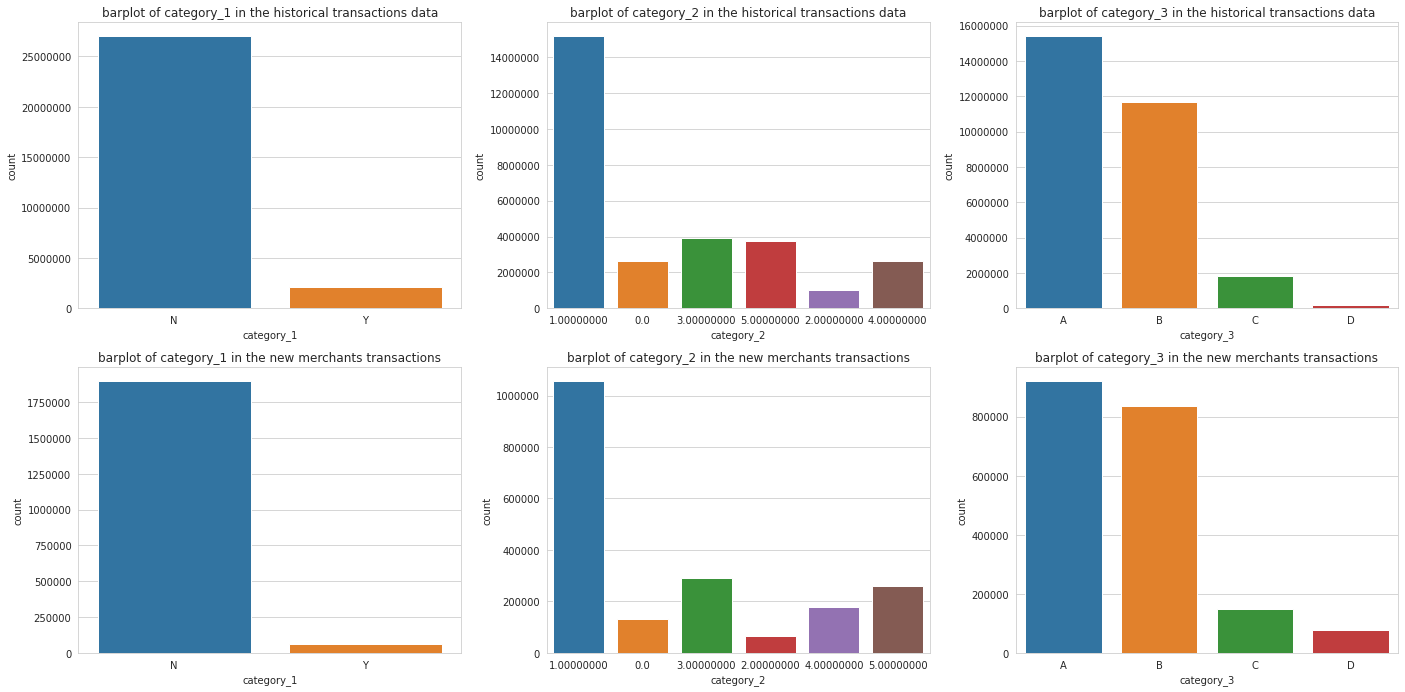

In [ ]:
plt.figure(figsize = (20,10))
plt.subplot(231)
sns.countplot(x= 'category_1', data = historical_transactions)
plt.ticklabel_format(style='plain', axis='y')
plt.title("barplot of category_1 in the historical transactions data")
plt.subplot(232)
sns.countplot(x= 'category_2', data = historical_transactions)
plt.ticklabel_format(style='plain', axis='y')
plt.title("barplot of category_2 in the historical transactions data")
plt.subplot(233)
sns.countplot(x= 'category_3', data = historical_transactions)
plt.ticklabel_format(style='plain', axis='y')
plt.title("barplot of category_3 in the historical transactions data")
plt.subplot(234)
sns.countplot(x= 'category_1', data = new_merchant_transactions)
plt.ticklabel_format(style='plain', axis='y')
plt.title("barplot of category_1 in the new merchants transactions")
plt.subplot(235)
sns.countplot(x= 'category_2', data = new_merchant_transactions)
plt.ticklabel_format(style='plain', axis='y')
plt.title("barplot of category_2 in the new merchants transactions")
plt.subplot(236)
sns.countplot(x= 'category_3', data = new_merchant_transactions, order=["A","B","C","D"])
plt.ticklabel_format(style='plain', axis='y')
plt.title("barplot of category_3 in the new merchants transactions")
plt.tight_layout(pad=2.08, h_pad=1.08, w_pad=1.08)
plt.show()

The distribution of these three category features are almost identical in historical and new transactions.This shows these Category feature represent the inately charcterstics of the transactions which is constant over the period.So, these features can be an importance feature in the decision function on final model.


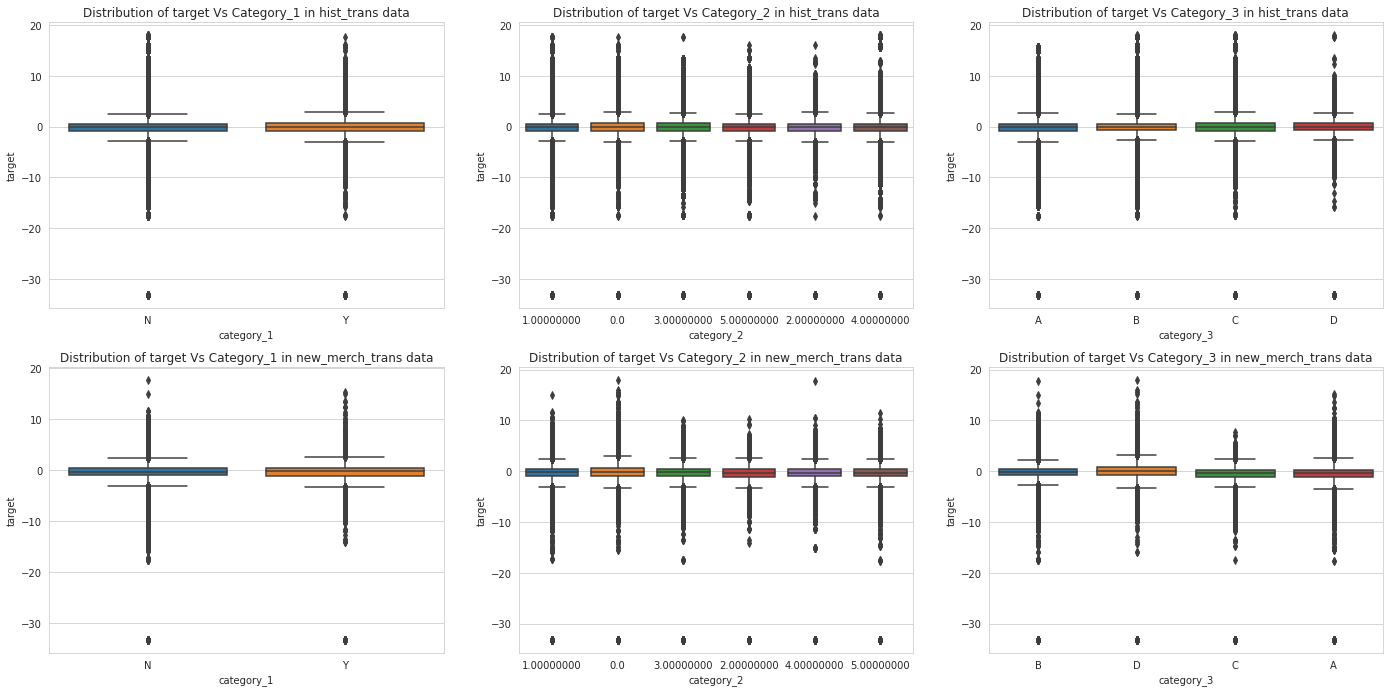

In [ ]:
plt.figure(figsize = (20,10))
plt.subplot(231)
sns.boxplot(y='target',data=historical_transactions, x='category_1')
plt.title("Distribution of target Vs Category_1 in hist_trans data")
plt.subplot(232)
sns.boxplot(y='target',data=historical_transactions, x='category_2')
plt.title("Distribution of target Vs Category_2 in hist_trans data")
plt.subplot(233)
sns.boxplot(y='target',data=historical_transactions, x='category_3')
plt.title("Distribution of target Vs Category_3 in hist_trans data")
plt.subplot(234)
sns.boxplot(y='target',data=new_merchant_transactions, x='category_1')
plt.title("Distribution of target Vs Category_1 in new_merch_trans data")
plt.subplot(235)
sns.boxplot(y='target',data=new_merchant_transactions, x='category_2')
plt.title("Distribution of target Vs Category_2 in new_merch_trans data")
plt.subplot(236)
sns.boxplot(y='target',data=new_merchant_transactions, x='category_3')
plt.title("Distribution of target Vs Category_3 in new_merch_trans data")
plt.tight_layout(pad=2.08, h_pad=1.08, w_pad=1.08)
plt.show()

These three category features doesn't explicity help to differentiate the target Score(Loyalty Score). Every category have outliers in each of the sub_categories. And Almost all the category have Same IQR range.

These anonymous features doesn't reveal any important info for further feature engineering of these categories. And, these boxplots shows the outlier's importance in these problem. Like, In category_3 feature, the "A" and "B" flags have large number of positive outliers than "D" and "C" in new_merchants_data.

we have to flag new_merchants_transactions in way to help to understand cardholder's 

#### Authorized Flag Feature

In [ ]:
historical_transactions.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id', 'target'],
      dtype='object')

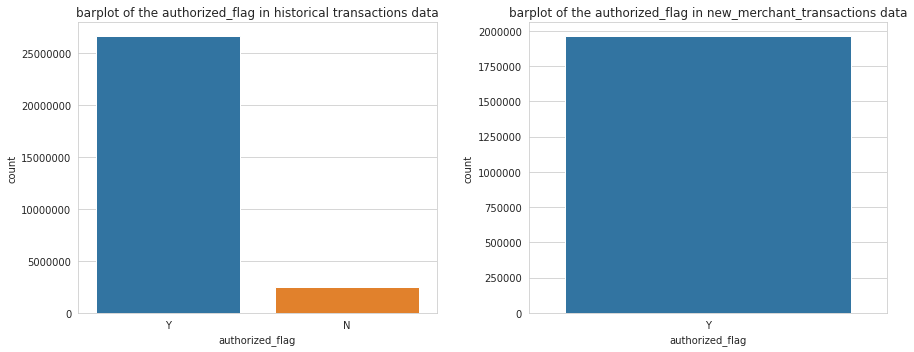

In [ ]:
plt.figure(figsize = (13,5))
plt.subplot(121)
sns.countplot(x= 'authorized_flag', data = historical_transactions)
plt.title("barplot of the authorized_flag in historical transactions data")
plt.ticklabel_format(style='plain', axis='y')
plt.subplot(122)
sns.countplot(x= 'authorized_flag', data = new_merchant_transactions)
plt.title("barplot of the authorized_flag in new_merchant_transactions data")
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

The new transactions have no "N" category in authorized_flag. This historical transactions have both "Y" and "N". 

The authorized_flag 
'Y' if approved, 'N' if denied - whether the transaction is approved or Denied.

This feature is an important feature for predicting the Loyalty score. because, if the card's transactions are approved most of time, there is a great chance the cards can have high Loyalty Score


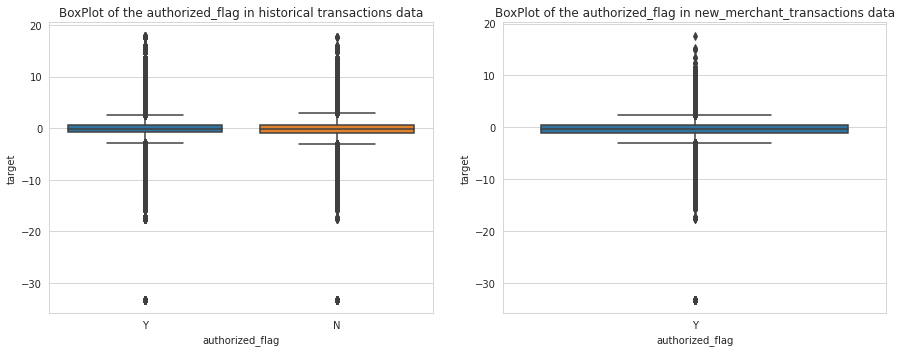

In [ ]:
plt.figure(figsize = (13,5))
plt.subplot(121)
sns.boxplot(y = 'target',x= 'authorized_flag', data = historical_transactions)
plt.title("BoxPlot of the authorized_flag in historical transactions data")
plt.subplot(122)
sns.boxplot(y = 'target',x= 'authorized_flag', data = new_merchant_transactions)
plt.title("BoxPlot of the authorized_flag in new_merchant_transactions data")
plt.tight_layout()
plt.show()

The authorized Flag also doesn't give a suspectble change in the IQR range between authorized and un_authorized transactions. 

Even for the un_authorized transactions card users have Same IQR. Because of the many transactions by an user, these un_authorized doesn't have much effect.

But this categorical features also should be included using response coding.

#### purchase_amount

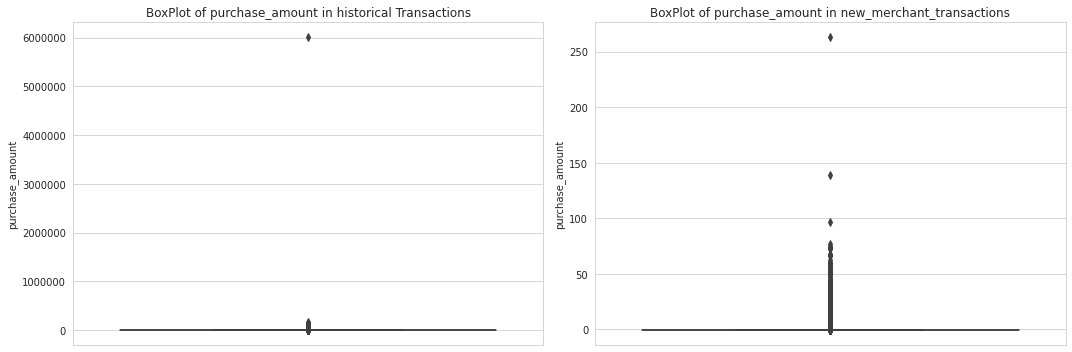

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.boxplot(y = 'purchase_amount', data = historical_transactions)
plt.title("BoxPlot of purchase_amount in historical Transactions")
plt.ticklabel_format(style='plain', axis='y')
plt.subplot(122)
sns.boxplot(y = 'purchase_amount', data = new_merchant_transactions)
plt.title("BoxPlot of purchase_amount in new_merchant_transactions")
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

In [ ]:
IQR(historical_transactions['purchase_amount'])

+------------+-----------------+
| Quantiles  |      Values     |
+------------+-----------------+
|    25%     |   -0.72037098   |
+------------+-----------------+
|    50%     |   -0.68839456   |
+------------+-----------------+
|    75%     |   -0.60341963   |
+------------+-----------------+
|    100%    | 6010603.9717525 |
+------------+-----------------+


The purchase amount is also normalized with added noise. 

The historical transactions have less number of outliers than the new merchants transactions.

The type of transactions in historical transactions differs from the new transactions in the distribution of purchase_amount also.

The IQR range value is very small. And there is one outlier which have 6010603.9717525. These outlier can skew the final model performance.

#### installments feature

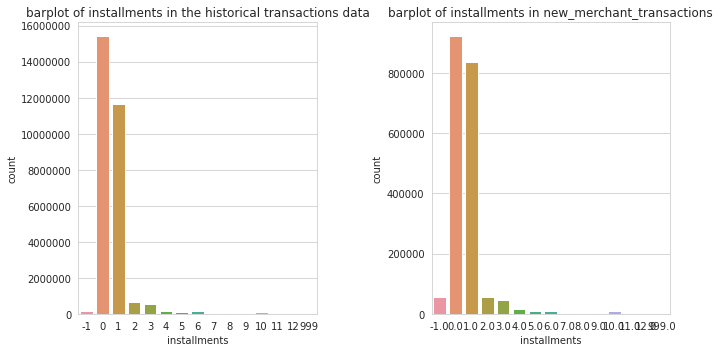

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sns.countplot(x= 'installments', data = historical_transactions)
plt.ticklabel_format(style='plain', axis='y')
plt.title("barplot of installments in the historical transactions data")
plt.subplot(122)
sns.countplot(x = 'installments', data = new_merchant_transactions)
plt.title("barplot of installments in new_merchant_transactions")
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

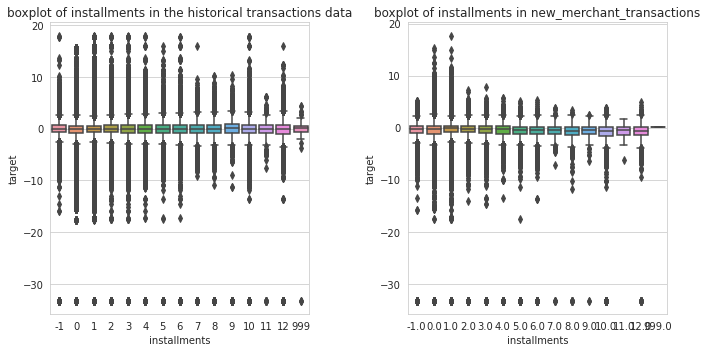

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sns.boxplot(y='target',x= 'installments', data = historical_transactions)
plt.title("boxplot of installments in the historical transactions data")
plt.subplot(122)
sns.boxplot(y='target',x = 'installments', data = new_merchant_transactions)
plt.title("boxplot of installments in new_merchant_transactions")
plt.tight_layout()
plt.show()

In [ ]:
IQR(historical_transactions['installments'])

+------------+--------+
| Quantiles  | Values |
+------------+--------+
|    25%     |  0.0   |
+------------+--------+
|    50%     |  0.0   |
+------------+--------+
|    75%     |  1.0   |
+------------+--------+
|    100%    | 999.0  |
+------------+--------+


In [ ]:
IQR(new_merchant_transactions['installments'])

+------------+--------+
| Quantiles  | Values |
+------------+--------+
|    25%     |  0.0   |
+------------+--------+
|    50%     |  1.0   |
+------------+--------+
|    75%     |  1.0   |
+------------+--------+
|    100%    | 999.0  |
+------------+--------+


The installments also have outliers, these outliers should be taken care of data preprocessing. In historical_transactions and new_merchants_transactions the 75% of installments are below 1. So, most of the payments through the cards are instant payments or short term installments.

###Month_lag

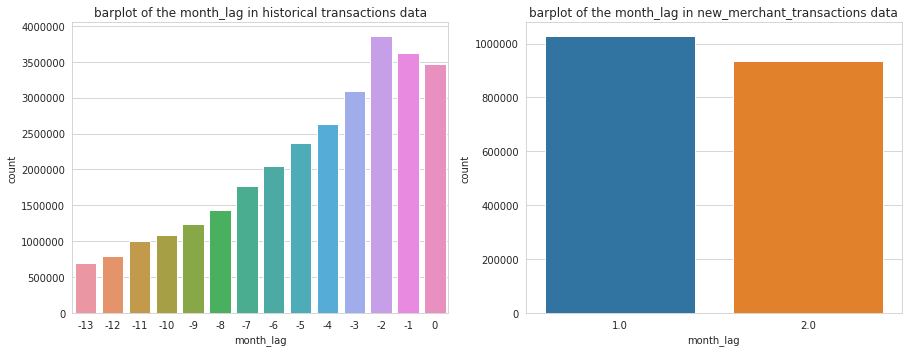

In [ ]:
plt.figure(figsize = (13,5))
plt.subplot(121)
sns.countplot(x= 'month_lag', data = historical_transactions)
plt.title("barplot of the month_lag in historical transactions data")
plt.ticklabel_format(style='plain', axis='y')
plt.subplot(122)
sns.countplot(x= 'month_lag', data = new_merchant_transactions)
plt.title("barplot of the month_lag in new_merchant_transactions data")
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

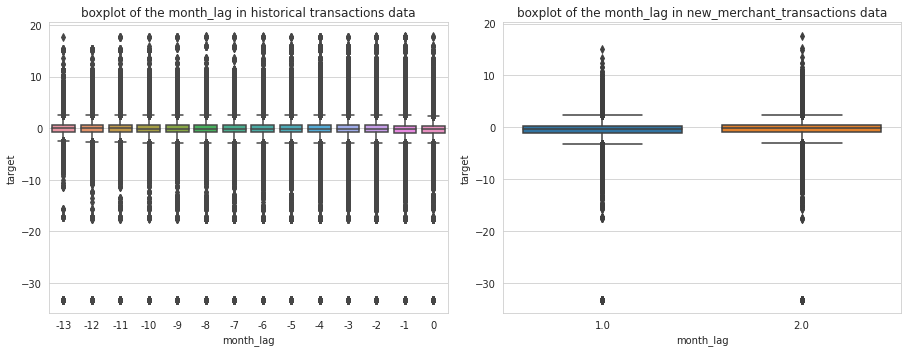

In [ ]:
plt.figure(figsize = (13,5))
plt.subplot(121)
sns.boxplot(y= 'target',x= 'month_lag', data = historical_transactions)
plt.title("boxplot of the month_lag in historical transactions data")
plt.subplot(122)
sns.boxplot(y= 'target',x= 'month_lag', data = new_merchant_transactions)
plt.title("boxplot of the month_lag in new_merchant_transactions data")
plt.tight_layout()
plt.show()

The Month_lag gives important info to predict the loyalty score. For a Purchase in installments, how many months the card lags from the actual end date of installment is the month_lag feature.

The historical_transactions have month_lags from 0 to 13. which means the cards with transactions in histortical_transactions data have lag of installments from 0 to 13. 

But, the new_merchant_transactions have month_lag 1 and 2 only.

This again proves the difference in the transactions type between the historical and new merchants.


### Purchase Date

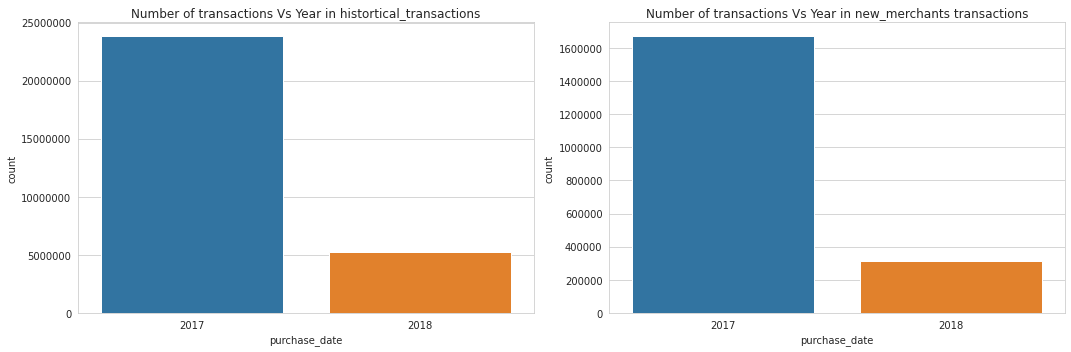

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(x = historical_transactions['purchase_date'].dt.year)
plt.title("Number of transactions Vs Year in histortical_transactions")
plt.ticklabel_format(style='plain', axis='y')
plt.subplot(122)
sns.countplot(x = new_merchant_transactions['purchase_date'].dt.year)
plt.title("Number of transactions Vs Year in new_merchants transactions")
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()


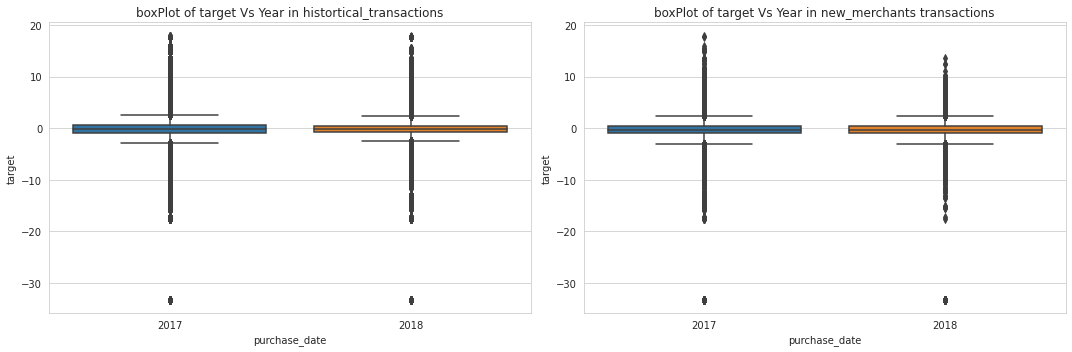

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.boxplot(y = historical_transactions['target'],x = historical_transactions['purchase_date'].dt.year)
plt.title("boxPlot of target Vs Year in histortical_transactions")
plt.subplot(122)
sns.boxplot(y =  new_merchant_transactions['target'],x = new_merchant_transactions['purchase_date'].dt.year)
plt.title("boxPlot of target Vs Year in new_merchants transactions")
plt.tight_layout()
plt.show()


In [ ]:
new_merchant_transactions['purchase_date'].dt.year.value_counts(normalize = True)*100

2017    84.234711
2018    15.765289
Name: purchase_date, dtype: float64

In [ ]:
historical_transactions['purchase_date'].dt.year.value_counts(normalize = True)*100

2017    81.845718
2018    18.154282
Name: purchase_date, dtype: float64

In Both the transactions, the transactions with respect to year distributed in the same way with more (81%-84%) transactions in 2017 and less (18-15.7%) transactions in 2018. 

The new_merchant_transactions are not the recent year transactions. 

This is the reason for the disparity in the purchase amount and installment features. 

The new_merchants have a different type of payment methods which differs from the historical_transactions merchants.

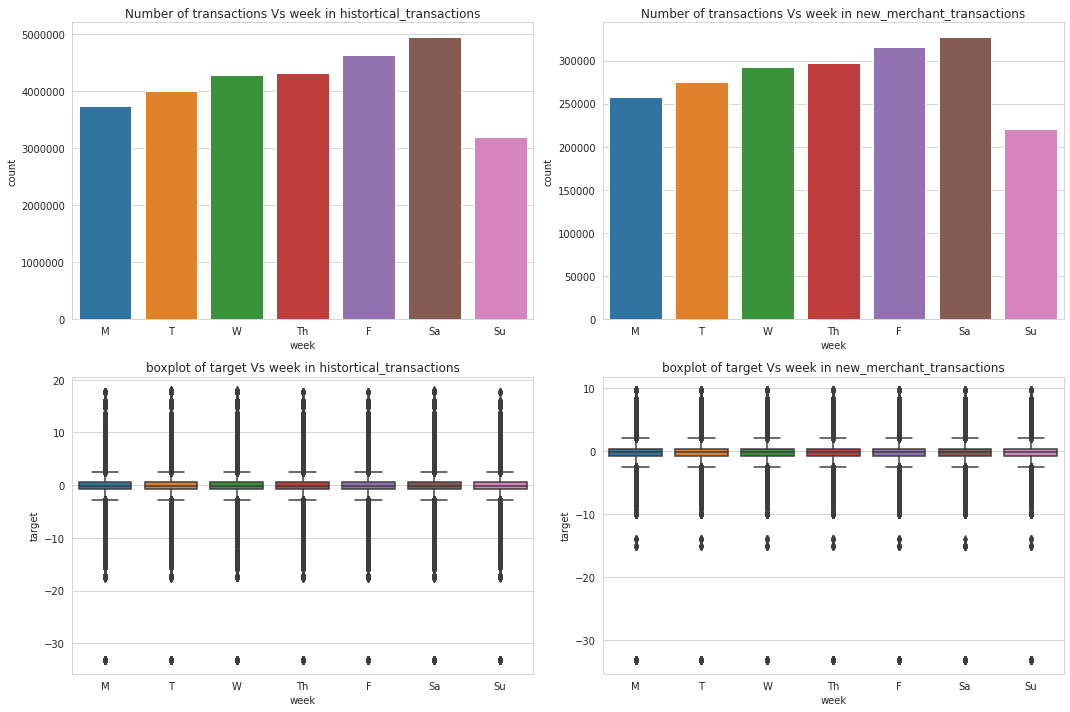

In [ ]:

plt.figure(figsize=(15,10))
plt.subplot(221)
sns.countplot(x = historical_transactions['purchase_date'].dt.dayofweek)
plt.title("Number of transactions Vs week in histortical_transactions")
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(range(7),labels=['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su'])
plt.xlabel('week')
plt.subplot(222)
sns.countplot(x = new_merchant_transactions['purchase_date'].dt.dayofweek)
plt.title("Number of transactions Vs week in new_merchant_transactions")
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(range(7),labels=['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su'])
plt.xlabel('week')
plt.subplot(223)
sns.boxplot(y = historical_transactions['target'],
             x = historical_transactions['purchase_date'].dt.dayofweek)
plt.title("boxplot of target Vs week in histortical_transactions")
plt.xticks(range(7),labels=['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su'])
plt.xlabel('week')
plt.subplot(224)
sns.boxplot(y = historical_transactions['target'],
               x = new_merchant_transactions['purchase_date'].dt.dayofweek)
plt.title("boxplot of target Vs week in new_merchant_transactions")
plt.xticks(range(7),labels=['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su'])
plt.xlabel('week')
plt.tight_layout()
plt.show()

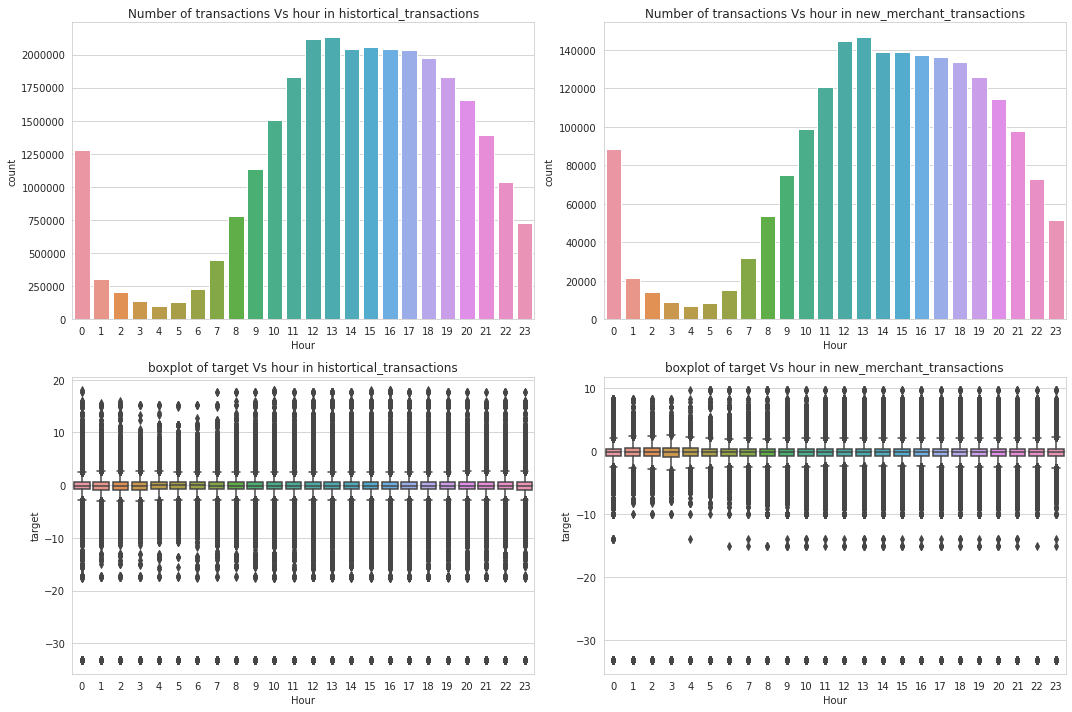

In [ ]:

plt.figure(figsize=(15,10))
plt.subplot(221)
sns.countplot(x = historical_transactions['purchase_date'].dt.hour)
plt.title("Number of transactions Vs hour in histortical_transactions")
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(range(24))
plt.xlabel('Hour')
plt.subplot(222)
sns.countplot(x = new_merchant_transactions['purchase_date'].dt.hour)
plt.title("Number of transactions Vs hour in new_merchant_transactions")
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(range(24))
plt.xlabel('Hour')
plt.subplot(223)
sns.boxplot(y = historical_transactions['target'],
            x = historical_transactions['purchase_date'].dt.hour)
plt.title("boxplot of target Vs hour in histortical_transactions")
plt.xticks(range(24))
plt.xlabel('Hour')
plt.subplot(224)
sns.boxplot(y = historical_transactions['target'],
            x = new_merchant_transactions['purchase_date'].dt.hour)
plt.title("boxplot of target Vs hour in new_merchant_transactions")
plt.xticks(range(24))
plt.xlabel('Hour')
plt.tight_layout()
plt.show()

From the distribution of both weekly and hourly transactions count, these transactions have not much difference in their distributions.

Since, the data given in the problem is a generated data and not a real time data. The distribution of the transactions over the purchase date is similar.

But, the type of transactions differs from historical and new_merchants in terms of purchase_amount,month_lag and installments.

By checking the number of merchants are in both historical and new_merchants transactions, we can get an informations exclusivness of the merchants.

In [ ]:
len(np.intersect1d(np.array(historical_transactions['merchant_id'].unique(), dtype='str'),
              np.array(new_merchant_transactions['merchant_id'].unique(), dtype='str')))

217794

In [ ]:
len(merchants['merchant_id'].unique())

334620

In [ ]:
(217808/334633)*100

65.08861947267603

The merchants involved in both the historical and new_merchants are 65% of the total merchants involved with Elo Brand. 

It concludes that the merchants are not different in the two transactions data rather the transactions type differs.

when accumulating the transactions for each card_id's, whether the card_id have more historical transactions or new_merchants transactions can help in the model's performance.

### Correlation between variables

In [23]:
d = {'A':1,'B':2,'C':3}
x = {'Y':1,'N':0}

cols = ['authorized_flag','category_3','month_lag','purchase_amount','state_id','subsector_id', 'category_2','installments']
n = new_merchant_transactions[cols]
n['category_3'] = n['category_3'].map(d)
n['authorized_flag'] = n['authorized_flag'].map(x)

n = n.dropna()

In [24]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(n.iloc[:,:].values, i) for i in range(n.shape[1])]
vif["features"] = n.columns
vif

,VIF Factor,features
0,31.880430,authorized_flag
1,1.493133,category_3
2,1.000173,month_lag
3,1.067406,purchase_amount
4,1.021572,state_id
5,1.010238,subsector_id
6,1.021653,category_2
7,1.528135,installments


The value for the authorized flag is somewhat higher, it is around 32 which indicates possible correlation. 
So this variable needs further investigation.

Other than the authorized flag the remaining variables doesn't look correlated. They are well under 2.


## Observations

1) THe files are train, test, new_merchant, merchant and historical transactions.

2) The features in train and test set are not much useful in predicting the target variable. There is need to engineer new features for predction model.

3) Distribution of both the train and test are almost identical. So there is no time based splitting in the make over of the data. And, it assures for prediction of the test data.

4) There are many missing values in the merchants,historical and new merchants transactions, so these missing values must be imputed in a intutive/effective way for better predciton.


5) The time features can reveal the inherent property of the transactions and the transactions are time dependent, the engineered features from the features like puchase_date will be useful in prediction.

6) The categorical features present across dataset are large in number than numerical features. One-hot encoding/response coding these features will help increase of the features in prediction.

7) The some features in the datasets are seems correlated and merchants data have high number of correlated features in it. This is revelated by the calcuation of the VIF Scores.

8) In the historical transactions data theres is this feature called authorized_flag count which indicates whether the transaction is authorized or not. There is very less number of transactions which is not authorized. Considering this flag features as a seperater in the feature engineering can results can give better predction.

9) Even the target variable is normally distributed there is a huge number of outliers which seems to be accumulated around -30. 

10) These outliers can be contain important trait in the prediction. So, Develop a model to predict outliers observations can results in good rmse values.

At the End of the Exploration of the transactions, merchants and train data, the given features of transactions are not big factor for the caculation of the target Score. 

There exist an aggregrated or engineered feature or features which can be helpful in predicting the target Score. 

With the different feature engineering techniques and market research techniques we have to produce the new feaures which may or may not be very useful in the predcition model. 

By implementing the major feature engineering ideas we have to produce features and build model upon it.

## Pre-processing

### Imputing using ML models

#### new_merchant_transactions and historical_transations

label encode some features before imputation using model will be helpful in better prediction model for impute of nan values

In [31]:
def encode_transactions(df):
  '''This function is specially for encode the categorical values of 
  transactions data
  parameters:
  df: the Dataframe where the label encoding will performed on certain features
  '''

  ## label encode the category 3 variables.
  d = {'A':1, 'B':2, 'C':3}
  df['category_3']= df['category_3'].map(d)
  #label encode the variables
  df = label_encoder(df, ['authorized_flag','category_1'])
  return df



In [9]:
## Reference: https://medium.com/towards-artificial-intelligence/handling-missing-data-for-advanced-machine-learning-b6eb89050357

def imputation_models(df, non_categorical, nan_features, models,model_names, filepath, format):
  '''This function is an universal function for imputation using 
  ML models
  parameters:
  df : The DataFrame
  non_categorical : List of non_categorical columns names which can't be used for prediction model
  nan_features: List of feature names which contains nan_values
  models: dict , Key: feature name , value: Model
  model_names: dict, key: feature name, value: name to be saved
  filepath: file path where the models are saved.
  format: format of model to be saved like '.sav'.
  '''

  ## collecting all the non-categorical features 
  a = df[non_categorical]

  ## dropping all the above collected features
  df.drop(non_categorical, axis=1, inplace=True)
  gc.collect()

  #select only columns which doesn't have any null values.
  no_nan = [c for c in df.columns if c not in nan_features]

  for feat in tqdm(nan_features):

    #test set by selecting only rows which are having null values
    df_null = df[df[feat].isna()]

    #train set by selecting rows which doesn't have any null values
    df_train = df.dropna()

    ##after getting the required features, 
    ##we have to build a model with no-null observations to predict the null observstions.

    file_directory = filepath+model_names[feat]+'.'+format

    clf = models[feat]

    if os.path.exists(file_directory):
      clf = pickle.load(open(file_directory, 'rb'))

    else:
      #fit the classifier to the train data
      clf.fit(df_train[no_nan], df_train[feat])
      pickle.dump(models[feat], open(file_directory, 'wb'))
      

    #make prediction only for the rows with null value
    df.loc[df[feat].isna(), feat] = clf.predict(df_null[no_nan])

    df[non_categorical] = a[non_categorical]

    
  del a
  return df

Imputation on new_merchant_transactions data

In [23]:
## since some changes are done previously loaded dataset, it is deleted and freshly loaded
del new_merchant_transactions
gc.collect()
new_merchant_transactions = pd.read_csv('/content/new_merchant_transactions.csv',parse_dates=["purchase_date"])
new_merchant_transactions = reduce_memory_usage(new_merchant_transactions)

Mem. usage decreased to 136.66 Mb (34.8% reduction)


In [24]:
non_categorical= ['card_id', 'merchant_id', 'purchase_date']
model_transacations = {'category_2':LogisticRegression(),
                       'category_3':LogisticRegression() }


model_names_transacations= {'category_2':'category_2_new_merchants_model',
                       'category_3':'category_3_new_merchants_model' }


## encoding the categorical features 
new_merchant_transactions = encode_transactions(new_merchant_transactions, prefix='new_merchant')

new_merchant_transactions = imputation_models(df = new_merchant_transactions,
                  non_categorical = non_categorical,
                  nan_features =  ['category_2', 'category_3'],
                  models = model_transacations,
                  model_names =model_names_transacations,
                  filepath = master_path,
                  format = '.sav')



  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:00<00:00,  3.18it/s]

100%|██████████| 2/2 [01:19<00:00, 39.63s/it]


In [26]:
new_merchant_transactions.isna().sum()

authorized_flag             0
city_id                     0
category_1                  0
installments                0
category_3                  0
merchant_category_id        0
month_lag                   0
purchase_amount             0
category_2                  0
state_id                    0
subsector_id                0
card_id                     0
merchant_id             26216
purchase_date               0
dtype: int64

In [27]:
new_merchant_transactions.to_csv(master_path+'new_merch_fill_na.csv', index=False)
del new_merchant_transactions
gc.collect()

24

Imputation on historical_transactions data

In [10]:
del historical_transactions
gc.collect()
historical_transactions = pd.read_csv('/content/historical_transactions.csv',parse_dates=["purchase_date"])
historical_transactions = reduce_memory_usage(historical_transactions)

Mem. usage decreased to 2026.75 Mb (34.8% reduction)


In [11]:
model_names_transacations= {'category_2':'category_2_historical_merchants_model',
                       'category_3':'category_3_historical_merchants_model' }

non_categorical= ['card_id', 'merchant_id', 'purchase_date']

model_transacations = {'category_2':LogisticRegression(),
                       'category_3':LogisticRegression() }


## encoding the categorical features 
historical_transactions = encode_transactions(historical_transactions, prefix='hist_merchant')

historical_transactions = imputation_models(df = historical_transactions,
                  non_categorical = non_categorical,
                  nan_features =  ['category_2', 'category_3'],
                  models = model_transacations,
                  model_names =model_names_transacations,
                  filepath = master_path,
                  format = '.sav')

100%|██████████| 2/2 [49:57<00:00, 1498.98s/it]


In [12]:
historical_transactions.isna().sum()

authorized_flag              0
city_id                      0
category_1                   0
installments                 0
category_3                   0
merchant_category_id         0
month_lag                    0
purchase_amount              0
category_2                   0
state_id                     0
subsector_id                 0
card_id                      0
merchant_id             138481
purchase_date                0
dtype: int64

In [13]:
historical_transactions.to_csv(master_path+'hist_merch_fill_na.csv', index=False)
del historical_transactions
gc.collect()

382

Only the merchant id have the null values now which represents there are transactions without merchants are availble. These can be dealt later.

#### Merchants data

In [15]:
del merchants
gc.collect()
merchants = pd.read_csv('/content/merchants.csv')
merchants = reduce_memory_usage(merchants)

Mem. usage decreased to 39.90 Mb (29.0% reduction)


In [22]:
non_categorical = ['merchant_id', 'category_2']
## removing the rows with infinity in avg_purchases_lag3 column
merchants = merchants[merchants['avg_purchases_lag3']!=np.inf]
## label encoding the categorical columns
merchants = label_encoder(merchants, ['category_4','category_1','most_recent_sales_range',
                              'most_recent_purchases_range'])

## models for columns 
model_merchants = {'avg_sales_lag3':KNeighborsRegressor(),
                       'avg_sales_lag6':KNeighborsRegressor(),
                   'avg_sales_lag12':KNeighborsRegressor()}

## column names for merhants 
model_names_merchants ={'avg_sales_lag3': 'avg_sales_lag3_reg_model',
                       'avg_sales_lag6':'avg_sales_lag6_reg_model',
                   'avg_sales_lag12':'avg_sales_lag12_reg_model'}



merchants = imputation_models(df = merchants,
                  non_categorical = non_categorical,
                  nan_features =  ['avg_sales_lag3','avg_sales_lag6',
                                   'avg_sales_lag12'],
                  models = model_merchants,
                  model_names = model_names_merchants,
                  filepath = master_path,
                  format = '.sav')

100%|██████████| 3/3 [00:17<00:00,  5.82s/it]


In [24]:
## models for columns 
model_merchants = {'category_2':LogisticRegression()}

## column names for merhants 
model_names_merchants ={'category_2': 'category_2_merchants_clf'}


merchants = imputation_models(df = merchants,
                  non_categorical = ['merchant_id'],
                  nan_features =  ['category_2'],
                  models = model_merchants,
                  model_names = model_names_merchants,
                  filepath = master_path,
                  format = '.sav')

100%|██████████| 1/1 [00:27<00:00, 27.34s/it]


In [26]:
merchants.isna().sum()

merchant_group_id              0
merchant_category_id           0
subsector_id                   0
numerical_1                    0
numerical_2                    0
category_1                     0
most_recent_sales_range        0
most_recent_purchases_range    0
avg_sales_lag3                 0
avg_purchases_lag3             0
active_months_lag3             0
avg_sales_lag6                 0
avg_purchases_lag6             0
active_months_lag6             0
avg_sales_lag12                0
avg_purchases_lag12            0
active_months_lag12            0
category_4                     0
city_id                        0
state_id                       0
category_2                     0
merchant_id                    0
dtype: int64

In [27]:
merchants.to_csv(master_path+'merchants_fill_na.csv', index=False)
del merchants
gc.collect()

478

## Feature Engineering

### One-hot Encoding

There are category features in the historical and new_merchants transactions should be one hot encoded transactions before accumulating the data to create features.

In [4]:
## Loading the preprocessed historical and merchants transactions data.
ht = pd.read_csv(master_path+'hist_merch_fill_na.csv',parse_dates=["purchase_date"])
##ht = reduce_memory_usage(ht)
new = pd.read_csv(master_path+'new_merch_fill_na.csv',parse_dates=["purchase_date"])
##new = reduce_memory_usage(new)

In [5]:
def oneHotEncoding(df, features):
  '''This function is for one-hot encoding the categorical features
  parameters:
  df: DataFrame
  features: Features needs to be one hot encoded.'''

  for feat in tqdm(features):
    unique_values = df[feat].unique()

    for cat in unique_values:
      df[feat+'={}'.format(cat)] = (ht[feat] == cat).astype(int)


In [6]:
## One-hot encoding the categorical features
categorical_features = ['category_2','category_3','month_lag']

## one-hot encoding historical transactions 
oneHotEncoding(ht, features=categorical_features)

## one-hot encoding new merchants transactions
oneHotEncoding(new, features=categorical_features)

gc.collect()

100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


7

In [ ]:
## saving the files intermittently so it will not lost the progress
# new.to_csv(master_path+'new_transactions_preprocessed.csv', index=False)
# ht.to_csv(master_path+'hist_transactions_preprocessed.csv', index=False)

### Aggregrated Features

The card_id is the primary key in the train and test data, so the features from transactions should be aggregated with card_id features.

- transaction count is first important info about the customer in aggregation of features.

The Purchase amount is one feature which can be aggregated to find money spend by each card_id with ELO. The purchase_amount is normalized with some added noise to anomonyize it. From the reference of kaggle discussion of radar, we can transform the purchase_amount into it's observed value.

In [9]:
## new_merchant_transactions 
new_merch_features = pd.DataFrame(new.groupby(['card_id']).size()).reset_index()
new_merch_features.columns = ['card_id', 'new_transc_count']
## historical_transactions 
historical_trans_features = pd.DataFrame(ht.groupby(['card_id']).size()).reset_index()
historical_trans_features.columns = ['card_id', 'hist_transc_count']

## reference: https://www.kaggle.com/raddar/towards-de-anonymizing-the-data-some-insights
#transforming the purchase amount
new['purchase_amount'] = np.round(new['purchase_amount'] / 0.00150265118 + 497.06, 2)
ht['purchase_amount'] = np.round(ht['purchase_amount'] / 0.00150265118 + 497.06, 2)

The id features canbe aggregated to understand the number users spread acros the different identifiers. if a card_id has large unique numbr city id's on thier transactions, there is high chance the user is loyal towards the brand.

In [9]:
aggs = {'city_id':['nunique'],
        'state_id' :['nunique'],
        'merchant_category_id':['nunique'],
        'subsector_id':['nunique'],
        'merchant_id':['nunique']}
new_merch_features = aggregated_features(new_merch_features, new,
                                         aggs, grpby='card_id',prefix='new_transc', use_col=True)
historical_trans_features = aggregated_features(historical_trans_features, ht,
                                                aggs, grpby='card_id',prefix='hist_transc', use_col=True)

100%|██████████| 5/5 [01:05<00:00, 13.13s/it]


The **category_1** Feature is a binary feature which can aggregated using the count of 1 and 0 in the transactions data for each card_id. And other features like mean and std can be calculated for the category_1 feature.

For **Authorized_flag** feature just like category_1, it is a binary feature which can as same a category_1.

In [10]:
aggs = {'category_1':['sum', 'mean'],
        'authorized_flag': ['sum', 'mean']}
new_merch_features = aggregated_features(new_merch_features, new,
                                         aggs, grpby='card_id',prefix='new_transc', use_col=True)
historical_trans_features = aggregated_features(historical_trans_features, ht,
                                                aggs, grpby='card_id',prefix='hist_transc', use_col=True)

100%|██████████| 2/2 [00:13<00:00,  6.57s/it]


The number of 0's and 1's are found by summming up the category_1 values and subracting it from the total count of transactions.

In [11]:
## category_1
new_merch_features['new_transc_category_1_sum_0'] = new_merch_features['new_transc_count'].values - \
new_merch_features['new_transc_category_1_sum'].values
historical_trans_features['hist_transc_category_1_sum_0'] = historical_trans_features['hist_transc_count'].values - \
historical_trans_features['hist_transc_category_1_sum'].values
## authorized_flag
new_merch_features['new_transc_denied_count'] = new_merch_features['new_transc_count'].values - \
new_merch_features['new_transc_authorized_flag_sum'].values
historical_trans_features['hist_transc_denied_count'] = historical_trans_features['hist_transc_count'].values - \
historical_trans_features['hist_transc_authorized_flag_sum'].values

For __installment__ feature all the aggregate features can be calculated because it is a ordianl numerical feature. Installments are one key aspects looks into credit score of the user. The credit Score can help in reveling the insights for loyalty.

In [12]:
aggs = {'installments':['mean', 'sum', 'max', 'min', 'std', 'skew']}
new_merch_features = aggregated_features(new_merch_features, new,
                                         aggs, grpby='card_id',prefix='new_transc', use_col=True)
historical_trans_features = aggregated_features(historical_trans_features, ht,
                                                aggs, grpby='card_id',prefix='hist_transc', use_col=True)

100%|██████████| 1/1 [01:10<00:00, 70.53s/it]


The feature __category_2__ and __category_3__ is a categorical feature with 5 unique values. And, In The category_2 feature is already one-hot coded, So for each category of category_2 feature the mean, sum and std can be calculated.

In [13]:

aggs = {'category_2=1.0':['sum', 'mean'],
        'category_2=3.0':['sum', 'mean'],
        'category_2=2.0':['sum', 'mean'],
        'category_2=4.0':['sum', 'mean'],
        'category_2=5.0':['sum', 'mean']}
new_merch_features = aggregated_features(new_merch_features, new,
                                         aggs, grpby='card_id',prefix='new_transc', use_col=True)
historical_trans_features = aggregated_features(historical_trans_features, ht,
                                                aggs, grpby='card_id',prefix='hist_transc', use_col=True)

100%|██████████| 5/5 [00:32<00:00,  6.57s/it]


In [14]:

aggs = {'category_3=2.0':['sum', 'mean'],
        'category_3=1.0':['sum', 'mean'],
        'category_3=3.0':['sum', 'mean']}
new_merch_features = aggregated_features(new_merch_features, new,
                                         aggs, grpby='card_id',prefix='new_transc', use_col=True)
historical_trans_features = aggregated_features(historical_trans_features, ht,
                                                aggs, grpby='card_id',prefix='hist_transc', use_col=True)

100%|██████████| 3/3 [00:17<00:00,  5.92s/it]


For **merchant_id**, we need info for each card_id, how many merchants are used by the card_id's. we are calculating count mean of transactions per card_id.

In [71]:
#find mean of the count of the transac for merchant id
historical_trans_features['hist_transc_merchant_id_count_mean'] = historical_trans_features['hist_transc_count'].values / (1.0+historical_trans_features['hist_transc_merchant_id_nunique'].values)


new_merch_features['new_transc_merchant_id_count_mean'] = new_merch_features['new_transc_count'].values/ (1.0+ new_merch_features['new_transc_merchant_id_nunique'].values)

For __month_lag__, for each card_id how many mont lagging and what is higgest month they are lagging these features can be aggregated.

In [15]:
def get_monthlag_stat(new_df, df, grpby, op, col, name, prefix=''):
  
  '''
  Thid function is group by the the specified column and find the count or sum depending on the input.
  Then perform basic operations like std, min, max etcetera
  parameters
  new_df - new features will be added to this DF
  df     - original DF
  grpby  - column using which we will group the data by
  col    - operations will be performed on this column
  name   - name for this columnn
  prefix - prefix to the column name
  '''
  if op == 'sum':
    tmp = df.groupby(grpby)[col].sum().unstack()
    new_df[prefix+grpby[1]+'_'+name[0]] = tmp.reset_index().iloc[:, -1].values
    new_df[prefix+grpby[1]+'_'+name[1]] = tmp.reset_index().iloc[:, -2].values
  
  if op == 'count':
    tmp = df.groupby(grpby)[col].count().unstack()
    # check if there is any null value and fill it with 0
    if tmp.isna().sum().any() > 0:
      tmp = tmp.fillna(0.0)
    new_df[prefix+grpby[1]+'_'+name[0]] = tmp.reset_index().iloc[:, 1:].std(axis=1).values
    new_df[prefix+grpby[1]+'_'+name[1]] = tmp.reset_index().iloc[:, 1:].max(axis=1).values
    
  return new_df

In [16]:
grpby_lag = ['card_id', 'month_lag']
historical_trans_features = get_monthlag_stat(historical_trans_features, ht, grpby=grpby_lag, op='count',
                                           col='purchase_amount', prefix='hist_transc_', name=['count_std','count_max'])

new_merch_features = get_monthlag_stat(new_merch_features, new, grpby=grpby_lag, op='count',
                                       col='purchase_amount', prefix='new_transc_', name=['count_std','count_max'])

The __Purchase_amount__ is a numerical features,so all the basic aggregations are done to create new features 

In [17]:
aggs = {'purchase_amount':['sum', 'mean', 'max', 'min', 'median', 'std', 'skew']}
new_merch_features = aggregated_features(new_merch_features, new,
                                         aggs, grpby='card_id',prefix='new_transc', use_col=True)
historical_trans_features = aggregated_features(historical_trans_features, ht,
                                                aggs, grpby='card_id',prefix='hist_transc', use_col=True)

## difference in the amount spend with cards
new_merch_features['new_transc_amount_diff'] = new_merch_features['new_transc_purchase_amount_max'].values - new_merch_features['new_transc_purchase_amount_min'].values

historical_trans_features['hist_transc_amount_diff'] = historical_trans_features['hist_transc_purchase_amount_max'].values - historical_trans_features['hist_transc_purchase_amount_min'].values                                               

100%|██████████| 1/1 [01:22<00:00, 82.39s/it]


succesive aggregation is a technique learned from a kernel on kaggle. This function successivly aggregated 

In [18]:
#https://www.kaggle.com/fabiendaniel/elo-world?scriptVersionId=8335387
def successive_aggregates(df, field1, field2):
  '''
  This function does is that it group the data twice and find
  basic aggregate values.
  First it will goup by card_id and all the specified column one by one.
  Then it will find the agg values like mean, min, max and std
  for the purchase amount for each group.
  Parameters:
  df      - original DataFrame
  field1  - first groupby along with card_id
  field2  - second grouby along with card_id
  '''
  t = df.groupby(['card_id', field1])[field2].mean()
  u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
  u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
  u.reset_index(inplace=True)
  return u


def successive_aggregation(new_df, df, field1='', field2 = '', other_columns=[]):
  '''
  This function is aggregates transactions columns successively with the columns mentioned.

  parameters:

  new_df  - The DataFrame which need to merged at end.
  df      - The DataFrame with all the column required.
  field1  - This is first field of many successive fields.
  field2 - The second field for the aggregation, which constant for which te aggregation done with other features.
  other_columns - all the other columns which will be later aggregated as the field_1.
  '''

  ## temp df for storing the aggregations 
  succ_agg = successive_aggregates(df, field1= field1, field2= field2)
  ## creating other successive features 
  for  col in tqdm(other_columns):
    succ_agg = succ_agg.merge(successive_aggregates(df, col, field2),on=['card_id'], how='left')
  
  ## merge with the new df finally
  new_df = new_df.merge(succ_agg, on = ['card_id'], how = 'left')

  return new_df

In [19]:
new_merch_features = successive_aggregation(new_merch_features, new,
                                            field1='category_1', field2 = 'purchase_amount',
                                            other_columns = ['installments', 'city_id', 
                                                             'merchant_category_id', 'merchant_id',
                                                             'subsector_id','category_2','category_3'])



historical_trans_features = successive_aggregation(historical_trans_features, ht,
                                            field1='category_1', field2 = 'purchase_amount',
                                            other_columns = ['installments', 'city_id', 
                                                             'merchant_category_id', 'merchant_id',
                                                             'subsector_id','category_2','category_3'])

100%|██████████| 7/7 [00:59<00:00,  8.56s/it]


Since, there is a chance of colab's ram crashing with increase in memory of data. Let's split the features into two halfs. 

Now, whatever features created will be stored in the file and upcoming features genereted using another and kernel stored another then merged at the end.

In [72]:
##saving the features into a file
new_merch_features.to_csv(master_path+'new_one_part.csv', index=False)
historical_trans_features.to_csv(master_path+'hist_one_part.csv', index=False)

In [73]:
del new_merch_features, historical_trans_features
gc.collect()

113

The __Time__ features are one of the important features because the predcition is a time based predcition. When the transactions happened is an important trait for prediction. 

The simple stastical features are created from column month_lag.

In [24]:
aggs = {'month_lag': ['nunique', 'mean', 'std', 'min', 'max', 'skew']}
new_merch_features = aggregated_features(new_merch_features, new,
                                         aggs, grpby='card_id',prefix='new_transc', use_col=True)
historical_trans_features = aggregated_features(historical_trans_features, ht,
                                                aggs, grpby='card_id',prefix='hist_transc', use_col=True)

100%|██████████| 1/1 [01:13<00:00, 73.88s/it]


The __purchase_date__ is the important time feature in transactions which gives the time_stamp of the purchases.

In [25]:
aggs = {'purchase_date': ['max','min']}
new_merch_features = aggregated_features(new_merch_features, new,
                                         aggs, grpby='card_id',prefix='new_transc', use_col=True)
historical_trans_features = aggregated_features(historical_trans_features, ht,
                                                aggs, grpby='card_id',prefix='hist_transc', use_col=True)

100%|██████████| 1/1 [00:06<00:00,  6.01s/it]


Difference in the max and min purchase_dates for a card_id and purchase_count ratio.

purchase_count_ratio is defined by total number of transactions divided by time period of between max and min date of purchase.

In [26]:
## diff in purchase_date from max to min 
new_merch_features['new_transc_purchase_date_diff'] = (new_merch_features['new_transc_purchase_date_max'] - new_merch_features['new_transc_purchase_date_min']).dt.days.values

## purchase_count_ratio
new_merch_features['new_transc_purchase_count_ratio'] = new_merch_features['new_transc_count'].values / (1.0 + new_merch_features['new_transc_purchase_date_diff'].values)

## diff in purchase_date from max to min 
historical_trans_features['hist_transc_purchase_date_diff'] = (historical_trans_features['hist_transc_purchase_date_max'] - historical_trans_features['hist_transc_purchase_date_min']).dt.days.values

## purchase_count_ratio
historical_trans_features['hist_transc_purchase_count_ratio'] = historical_trans_features['hist_transc_count'].values / (1.0 + historical_trans_features['hist_transc_purchase_date_diff'].values)

Next, Some features about day of the purchase. 

- Whether the purchase_date is on weekday or weekend by is_weekend feature. Since, the is_weekend is a binary feature, we can aggeregate the feature with simple stats mean,max,sum etc.

In [27]:

#is_weekend is a feature which purchase_date is weekend or weekday.
new['is_weekend'] = new['purchase_date'].dt.dayofweek
#>5 to check whether the day is sat or sunday then, if it is then assign a val 1 else 0
new['is_weekend'] = new['is_weekend'].apply(lambda x: 1 if x >= 5 else 0).values
ht['is_weekend'] = ht['purchase_date'].dt.dayofweek
#>5 to check whether the day is sat or sunday then, if it is then assign a val 1 else 0
ht['is_weekend'] = ht['is_weekend'].apply(lambda x: 1 if x >= 5 else 0).values

## aggregate features for is_weekend 
aggs = {'is_weekend': ['sum','mean']}
new_merch_features = aggregated_features(new_merch_features, new,
                                         aggs, grpby='card_id',prefix='purchase_is_weekend_', use_col=True)
historical_trans_features = aggregated_features(historical_trans_features, ht,
                                                aggs, grpby='card_id',prefix='purchase_is_weekend_', use_col=True)

100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


__Month_diff__ is another feature which can dervied from the purchase_date feature. Since, all the transactions occurs in 2017 - 2018. Bt taking the last day of 2018 year as the reference date and find the number of months between the reference_date and purchase_date. This month_difference reveals the recency and frequency of the purchases.

In [28]:
reference_date = '2018-12-31'
reference_date = pd.to_datetime(reference_date)
## calcuating month difference 
new['month_diff'] = (reference_date - new['purchase_date']).dt.days // (30 + new['month_lag'])
ht['month_diff'] = (reference_date - ht['purchase_date']).dt.days // (30 + ht['month_lag'])

## calculating the aggerated features like ['mean', 'min', 'max'] for month_diff column.

aggs = {'month_diff': ['mean', 'min', 'max']}
new_merch_features = aggregated_features(new_merch_features, new,
                                         aggs, grpby='card_id',prefix='new_transc', use_col=True)
historical_trans_features = aggregated_features(historical_trans_features, ht,
                                                aggs, grpby='card_id',prefix='hist_transc', use_col=True)

100%|██████████| 1/1 [00:08<00:00,  8.97s/it]


The ratio of purchase amount by month_diff is another feature which help to reveal the card_id's financial capcity and purchase_pattern.

In [29]:
new['amount_month_ratio'] = new['purchase_amount'].values / (1.0 + new['month_diff'].values)
ht['amount_month_ratio'] = ht['purchase_amount'].values / (1.0 + ht['month_diff'].values)

## aggregated features on the amount ratio and month_lag.
aggs = {'amount_month_ratio': ['mean', 'std', 'min', 'max', 'skew'],
        'month_lag=1': ['sum','mean'],
        'month_lag=2':['sum','mean']}
new_merch_features = aggregated_features(new_merch_features, new,
                                         aggs, grpby='card_id',prefix='new_transc', use_col=True)

aggs = {'amount_month_ratio': ['mean', 'std', 'min', 'max', 'skew'],
        'month_lag=0': ['sum','mean'],
        'month_lag=-1':['sum','mean'],
        'month_lag=-2':['sum','mean']}
historical_trans_features = aggregated_features(historical_trans_features, ht,
                                                aggs, grpby='card_id',prefix='hist_transc', use_col=True)

100%|██████████| 4/4 [01:28<00:00, 22.02s/it]


Other Time Stamp features are dayofweek,week and hour. These features are ordinal numerical features. And, From these features we can calcuate the simple stats as aggeregated features.

New merchants data only have two month lags 1 and 2, so we can do simple ratio on it for an another feature. And, the same can be done on the historical transactions as well.

In [34]:
## month_lag ratio between two month_lags.
new_merch_features['new_transc_month_lag_1_2_ratio'] = new_merch_features['new_transc_month_lag=1_sum'] \
                                                                  / (1.0+ new_merch_features['new_transc_month_lag=2_sum'])


## month_lag ratio in historical transactions

historical_trans_features['hist_transc_month_lag_0_-1_ratio'] = historical_trans_features['hist_transc_month_lag=0_sum'] \
                                                                  / (1.0+ historical_trans_features['hist_transc_month_lag=-1_sum'])

historical_trans_features['hist_transc_month_lag_0_-2_ratio'] = historical_trans_features['hist_transc_month_lag=0_sum'] \
                                                                  / (1.0+ historical_trans_features['hist_transc_month_lag=-2_sum'])
tmp = historical_trans_features[['hist_transc_month_lag=0_sum','hist_transc_month_lag=-1_sum','hist_transc_month_lag=-2_sum']].sum(axis=1)

## ratio of the summed month lags with the transaction count
historical_trans_features['hist_transc_month_lag_sum_ratio'] = tmp / (1.0+ historical_trans_features['hist_transc_count'])                                                                 

In [35]:
##saving the features into a file
new_merch_features.to_csv(master_path+'new_second_part.csv', index=False)
historical_trans_features.to_csv(master_path+'hist_second_part.csv', index=False)

In [36]:
del new_merch_features, historical_trans_features
gc.collect()

517

Some More time features, Like the difference between the purchases and occasion of the purchases

In [10]:
def getdatefeatures(df):
  '''This function is to get all the numerical 
  features from the purchase Date feature
  Parameters:
  df: The dataFrame'''

  df['week'] = df['purchase_date'].dt.week.values
  df['dayofweek'] = df['purchase_date'].dt.dayofweek.values
  df['hour'] = df['purchase_date'].dt.hour.values


## extracting the day, hour , week from the purchase_date.

getdatefeatures(ht)
getdatefeatures(new)

In [11]:
## aggregated features on  day, hour , week
aggs = {'week': ['nunique', 'mean', 'min', 'max'],
        'dayofweek': ['nunique', 'mean', 'min', 'max'],
        'hour':['nunique', 'mean', 'min', 'max']}

new_merch_features = aggregated_features(new_merch_features, new,
                                         aggs, grpby='card_id',prefix='new_transc', use_col=True)

historical_trans_features = aggregated_features(historical_trans_features, ht,
                                                aggs, grpby='card_id',prefix='hist_transc', use_col=True)

100%|██████████| 3/3 [01:02<00:00, 20.77s/it]


The difference between two purchase revels the frequency of the purchase. So, For example an card_id is doing one jan and another on dec next year, the frequency of the usage is very low. The frquency of usage is a very critical feature for the loyalty predcition.

In [12]:
def timebtwpurchases(df, groupby, column, shift = 1):

  ''' This function is to extract the shifted columns between the purchases.

  parameters:

  df - The DataFrame
  groupby - The col by which the data is grouped by
  column - column for which the shifted features are calcuated
  shift - how many time periods shift is required
  '''


  ## first to sort values by the column for which shifting needed.

  df = df.sort_values(column)

  for i in range(shift):
    ## creating the shited time between two purchases in a group
    df['prev_{}_'.format(i+1)+column] = df.groupby([groupby])[column].shift(i+1)
    ## calcuating the shift in different time representations like days,seconds,hours
    df['purchase_date_diff_{}_days'.format(i+1)] = (df[column] - df['prev_{}_'.format(i+1)+column]).dt.days.values
    df['purchase_date_diff_{}_seconds'.format(i+1)] = df['purchase_date_diff_{}_days'.format(i+1)].values * 24 * 3600
    df['purchase_date_diff_{}_seconds'.format(i+1)] += (df[column] - df['prev_{}_'.format(i+1)+column]).dt.seconds.values
    df['purchase_date_diff_{}_hours'.format(i+1)] = df.iloc[:, -1].values // 3600

  return df

In [13]:
## difference in time between the purchases
new = timebtwpurchases(new, 'card_id', 'purchase_date', 2)

In [14]:
## aggregation difference in time features
aggs = {'purchase_date_diff_1_seconds': ['mean', 'std', 'max', 'min'],
        'purchase_date_diff_1_days': ['mean', 'std', 'max', 'min'],
        'purchase_date_diff_1_hours': ['mean', 'std', 'max', 'min']}


new_merch_features = aggregated_features(new_merch_features, new,
                                         aggs, grpby='card_id',prefix='new_transc', use_col=True)


100%|██████████| 3/3 [00:19<00:00,  6.44s/it]


In [15]:
## aggregation difference in time features
aggs = {'purchase_date_diff_2_seconds': ['mean', 'std', 'max', 'min'],
        'purchase_date_diff_2_days': ['mean', 'std', 'max', 'min'],
        'purchase_date_diff_2_hours': ['mean', 'std', 'max', 'min']}


new_merch_features = aggregated_features(new_merch_features, new,
                                         aggs, grpby='card_id',prefix='new_transc', use_col=True)

100%|██████████| 3/3 [00:19<00:00,  6.54s/it]


In [16]:
##saving the features into a file
new_merch_features.to_csv(master_path+'new_third_part.csv', index=False)
historical_trans_features.to_csv(master_path+'hist_third_part.csv', index=False)

The holidays and other occassion have a special place in the usage of cards, that when the promotions are much required to attract the consumers to use the ELO cards. So, by identifying the user's activity during these holidays or other offer periods can help in predicting the Loyalty Score. The purchases can be done after or before the holidays because of these sales. For our purpose let's consider 75 days before the holdiay as the purchase days.

In [4]:
holidays = {'EasterDay_2017' : '2017-04-16',
            'AllSoulsDay_2017': '2017-11-2',
            'ChristmasDay_2017': '2017-12-25',
            'FathersDay_2017': '2017-08-13',
            'ChildrenDay_2017':'2017-10-12',
            'BlackFriday_2017':'2017-11-24',
            'ValentineDay_2017':'2017-06-12',
            'MothersDay_2018':'2018-05-13'}


In [10]:

## we are gonna represent number days as the feature. if the values is above 75 then it will become zero.
for day, date in holidays.items():
  ## new_transactions 
  new[day] = (pd.to_datetime(date) - new['purchase_date']).dt.days
  new[day] = new[day].apply(lambda x: x if x > 0 and x < 75 else 0)

  ## aggregation of holidays
aggs = dict(zip(holidays.keys(),[['mean'] for x in holidays.keys()]))

new_merch_features = aggregated_features(new_merch_features, new,
                                         aggs, grpby='card_id',prefix='new_transc', use_col=True)


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


With newly created holiday features we can find aggregated feature like mean and min. Since other stat features won't be much useful.

In [ ]:
aggs = {'category_2=1.0':['sum', 'mean'],
        'category_2=3.0':['sum', 'mean'],
        'category_2=2.0':['sum', 'mean'],
        'category_2=4.0':['sum', 'mean'],
        'category_2=5.0':['sum', 'mean']}
new_merch_features = aggregated_features(new_merch_features, new,
                                         aggs, grpby='card_id',prefix='new_transc', use_col=True)
historical_trans_features = aggregated_features(historical_trans_features, ht,
                                                aggs, grpby='card_id',prefix='hist_transc', use_col=True)

In [ ]:
## we are gonna represent number days as the feature. if the values is above 75 then it will become zero.
# for day, date in holidays.items():
#   ## historical_transactions
#   ht[day] = (pd.to_datetime(date) - ht['purchase_date']).dt.days
#   ht[day] = ht[day].apply(lambda x: x if x > 0 and x < 75 else 0)


# ## aggregation of holidays
# aggs = dict(zip(holidays.keys(),[['mean'] for x in holidays.keys()]))

#historical_trans_features = aggregated_features(historical_trans_features, new,
#                                          aggs, grpby='card_id',prefix='hist_transc', use_col=True)

In [ ]:
# ht = timebtwpurchases(ht, 'card_id', 'purchase_date', 1)
# ## aggregation difference in time features
# aggs = {'purchase_date_diff_1_seconds': ['mean', 'std', 'max', 'min'],
#         'purchase_date_diff_1_days': ['mean', 'std', 'max', 'min'],
#         'purchase_date_diff_1_hours': ['mean', 'std', 'max', 'min']}


# historical_trans_features = aggregated_features(historical_trans_features, new,
#                                          aggs, grpby='card_id',prefix='hist_transc', use_col=True)


In [11]:
new_merch_features.to_csv(master_path+'new_fourth_part.csv', index=False)
historical_trans_features.to_csv(master_path+'hist_fourth_part.csv', index=False)

### Summary on Feature Engineering

1) After One-hot encoded the categorical features in the transactions, categorical features like "category_1","category_2","authorized_flag" are aggregated to form the basic stat features "sum" and "mean".


2) Next, the numerical features like installments and purchase_amount are aggregated with stat features ['mean', 'sum', 'max', 'min', 'std', 'skew'].

3) The Month_lag which is an important feature for loyalty predcition, the number of payment pendings(month_lag) and it's max value are aggregated by grouping.

4) Then time features like purchase_date are used extensively understant the time and frequency of the purchases.

5) With the Help of purchase_date, we also formed features about the purpose and occasion of the purchase.

## Preparation of Data For Modeling

In [5]:
func_remove_col = lambda col : col not in ['new_transc_count',
                                           'hist_transc_count']
## new_transactions 
new_features_one = pd.read_csv(master_path+'new_one_part.csv')
new_features_second = pd.read_csv(master_path+'new_second_part.csv', usecols= func_remove_col)
new_features_third = pd.read_csv(master_path+'new_third_part.csv', usecols= func_remove_col)
new_features_fourth = pd.read_csv(master_path+'new_fourth_part.csv', usecols= func_remove_col)

In [6]:
## historical_transactions 
hist_features_one = pd.read_csv(master_path+'hist_one_part.csv')
hist_features_second = pd.read_csv(master_path+'hist_second_part.csv', usecols= func_remove_col)
hist_features_third = pd.read_csv(master_path+'hist_third_part.csv', usecols= func_remove_col)
hist_features_fourth = pd.read_csv(master_path+'hist_fourth_part.csv', usecols= func_remove_col)

Merging the all the features of historical and new_transactions.

In [7]:
new_transc_feature_dfs = [new_features_one,new_features_second,
                new_features_third,new_features_fourth]

hist_transc_feature_dfs = [hist_features_one,hist_features_second,
                hist_features_third,hist_features_fourth]   

## https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns

new_transc_features = reduce(lambda left,right: pd.merge(left,right,on='card_id', how='left'), new_transc_feature_dfs)

hist_transc_features = reduce(lambda left,right: pd.merge(left,right,on='card_id', how='left'), hist_transc_feature_dfs)      

Loading the train and test data

In [8]:
train                    = pd.read_csv('/content/train.csv', parse_dates=["first_active_month"])
test                     = pd.read_csv(master_path+'test_fill_na.csv', parse_dates=["first_active_month"])

In [9]:
##merging the new features with the train and test Data
train = reduce(lambda left,right: pd.merge(left,right,on='card_id', how='left'), [train,new_transc_features,
                                                                          hist_transc_features])

test  = reduce(lambda left,right: pd.merge(left,right,on='card_id', how='left'), [test,new_transc_features,
                                                                          hist_transc_features])

Since train and test df's have target values. As seen in the train and test data eda, target value has outliers. We can make the outliers as the binary feature whether card's target value is outliers or not.

In [10]:
train['outliers'] = 0
train[train['target'] < -30]['outliers'] = 1

The train and test also have a time feature, 'first_active_month'. We should make some time features from this first_active_month.

In [11]:
reference_date = pd.to_datetime('2018-12-31')

for df in [train, test]:
    #extracting the year and month
    df['year'] = df['first_active_month'].dt.year.values
    df['month'] = df['first_active_month'].dt.month.values
    ## extracting elapsed dates 
    df['hist_transc_no_of_days'] = ( pd.to_datetime(df['hist_transc_purchase_date_max']) -  pd.to_datetime(df['hist_transc_purchase_date_max'])).dt.days
    df['new_transc_no_of_days'] = (pd.to_datetime(df['new_transc_purchase_date_max']) - pd.to_datetime(df['new_transc_purchase_date_max'])).dt.days
    ## recency of the puchases in terms of fractions
    df['hist_transc_purchase_active_diff'] = (pd.to_datetime(df['hist_transc_purchase_date_min'].astype(str).apply(lambda x: x[:7])) - df['first_active_month']).dt.days.values
    df['hist_transc_purchase_recency'] = (reference_date - pd.to_datetime(df['hist_transc_purchase_date_max']))/(24*np.timedelta64(1, 'h'))
    df['new_transc_purchase_recency'] = (reference_date - pd.to_datetime(df['new_transc_purchase_date_max']))/(24*np.timedelta64(1, 'h'))  

In [12]:
train = label_encoder(train, cols = ['month','year'])
test  = label_encoder(test, cols = ['month','year'])

#### RFM Index and RFM Score

RFM analysis is a market research methodolgy which uses Three measures of the transactions of cardholders to categorize the cardholders.

- R - Recency - Days since last transactions 
- F - Frequency - Frequency of the transactions 
- M - Monetary value - Total money spent by the customer/card holder

here for calculating the RFM index and RFM score, we need to use qunatiles according to the [article](https://towardsdatascience.com/find-your-best-customers-with-customer-segmentation-in-python-61d602f9eee6) by susan Li. So, we are gonna group the recency ,frequency and Monetary in qunatiles.

In [13]:
## qunatiles of RFM
quantiles_new = train[['new_transc_purchase_recency','new_transc_count','new_transc_purchase_amount_sum']].quantile(q=[0.011,0.05,0.25,0.5,0.75,0.95,0.989]).to_dict()
## quantiles of RFM with historical transactions
quantiles_hist = train[['hist_transc_purchase_recency','hist_transc_count','hist_transc_purchase_amount_sum']].quantile(q=[0.011,0.05,0.25,0.5,0.75,0.95,0.989]).to_dict()

In [14]:
## reference: https://towardsdatascience.com/find-your-best-customers-with-customer-segmentation-in-python-61d602f9eee6
def RScore(x,p,d):
    if x <= d[p][0.011]:
        return 1
    elif x <= d[p][0.050]:
        return 2
    elif x <= d[p][0.25]: 
        return 3
    elif x <= d[p][0.5]:
        return 4
    elif x <= d[p][0.75]:
        return 5
    elif x <= d[p][0.95]:
        return 6
    elif x <= d[p][0.989]:
        return 7
    else:
        return 8
    
def FMScore(x,p,d):
    if x <= d[p][0.011]:
        return 8
    elif x <= d[p][0.050]:
        return 7
    elif x <= d[p][0.25]: 
        return 6
    elif x <= d[p][0.5]:
        return 5
    elif x <= d[p][0.75]:
        return 4
    elif x <= d[p][0.95]:
        return 3
    elif x <= d[p][0.989]:
        return 2
    else:
        return 1

In [15]:
def rfm(df,quantiles, transc):
  '''This function is to calcualte RFM score and RFM index for the dataframe with RFM.

  parameters:

  df: The DataFrame
  quantiles: qunatiles for the RFM score and index to calculated
  transc : type of transactions(new or hist)

  '''

  ## grouping quantiles
  df[transc+'r_quantile'] = df[transc+'purchase_recency'].apply(RScore, args=(transc+'purchase_recency',quantiles))
  df[transc+'f_quantile'] = df[transc+'count'].apply(FMScore, args=(transc+'count',quantiles))
  df[transc+'m_quantile'] = df[transc+'purchase_amount_sum'].apply(FMScore, args=(transc+'purchase_amount_sum',quantiles))
  ## calaculating RFM index and RFMScore
  df[transc+'RFMindex'] = df[transc+'r_quantile'].map(str)+df[transc+'f_quantile'].map(str)+df[transc+'m_quantile'].map(str)                       
  df[transc+'RFMScore'] = df[transc+'r_quantile']+df[transc+'f_quantile']+df[transc+'m_quantile'] 

In [16]:
## RFM score calculation
for df in [train,test]:
  rfm(df,quantiles_new,transc = 'new_transc_')
  rfm(df,quantiles_hist,transc = 'hist_transc_')

In [17]:
pd.set_option('display.max_columns', None)
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,new_transc_count,new_transc_city_id_nunique,new_transc_state_id_nunique,new_transc_merchant_category_id_nunique,new_transc_subsector_id_nunique,new_transc_merchant_id_nunique,new_transc_category_1_sum,new_transc_category_1_mean,new_transc_authorized_flag_sum,new_transc_authorized_flag_mean,new_transc_category_1_sum_0,new_transc_denied_count,new_transc_installments_mean,new_transc_installments_sum,new_transc_installments_max,new_transc_installments_min,new_transc_installments_std,new_transc_installments_skew,new_transc_category_2=1.0_sum,new_transc_category_2=1.0_mean,new_transc_category_2=3.0_sum,new_transc_category_2=3.0_mean,new_transc_category_2=2.0_sum,new_transc_category_2=2.0_mean,new_transc_category_2=4.0_sum,new_transc_category_2=4.0_mean,new_transc_category_2=5.0_sum,new_transc_category_2=5.0_mean,new_transc_merchant_id_count_mean,new_transc_month_lag_count_std,new_transc_month_lag_count_max,new_transc_purchase_amount_sum,new_transc_purchase_amount_mean,new_transc_purchase_amount_max,new_transc_purchase_amount_min,new_transc_purchase_amount_median,new_transc_purchase_amount_std,new_transc_purchase_amount_skew,new_transc_amount_diff,category_1_purchase_amount_mean_x,category_1_purchase_amount_min_x,category_1_purchase_amount_max_x,category_1_purchase_amount_std_x,installments_purchase_amount_mean_x,installments_purchase_amount_min_x,installments_purchase_amount_max_x,installments_purchase_amount_std_x,city_id_purchase_amount_mean_x,city_id_purchase_amount_min_x,city_id_purchase_amount_max_x,city_id_purchase_amount_std_x,merchant_category_id_purchase_amount_mean_x,merchant_category_id_purchase_amount_min_x,merchant_category_id_purchase_amount_max_x,merchant_category_id_purchase_amount_std_x,merchant_id_purchase_amount_mean_x,merchant_id_purchase_amount_min_x,merchant_id_purchase_amount_max_x,merchant_id_purchase_amount_std_x,subsector_id_purchase_amount_mean_x,subsector_id_purchase_amount_min_x,subsector_id_purchase_amount_max_x,subsector_id_purchase_amount_std_x,category_2_purchase_amount_mean_x,category_2_purchase_amount_min_x,category_2_purchase_amount_max_x,category_2_purchase_amount_std_x,category_3_purchase_amount_mean_x,category_3_purchase_amount_min_x,category_3_purchase_amount_max_x,category_3_purchase_amount_std_x,new_transc_category_3=2.0_sum,new_transc_category_3=2.0_mean,new_transc_category_3=1.0_sum,new_transc_category_3=1.0_mean,new_transc_category_3=3.0_sum,new_transc_category_3=3.0_mean,new_transc_month_lag_nunique,new_transc_month_lag_mean,new_transc_month_lag_std,new_transc_month_lag_min,new_transc_month_lag_max,new_transc_month_lag_skew,new_transc_purchase_date_max,new_transc_purchase_date_min,new_transc_purchase_date_diff,new_transc_purchase_count_ratio,purchase_is_weekend__is_weekend_sum_x,purchase_is_weekend__is_weekend_mean_x,new_transc_month_diff_mean,new_transc_month_diff_min,new_transc_month_diff_max,new_transc_amount_month_ratio_mean,new_transc_amount_month_ratio_std,new_transc_amount_month_ratio_min,new_transc_amount_month_ratio_max,new_transc_amount_month_ratio_skew,new_transc_month_lag=1_sum,new_transc_month_lag=1_mean,new_transc_month_lag=2_sum,new_transc_month_lag=2_mean,new_transc_month_lag_1_2_ratio,new_transc_week_nunique,new_transc_week_mean,new_transc_week_min,new_transc_week_max,new_transc_dayofweek_nunique,new_transc_dayofweek_mean,new_transc_dayofweek_min,new_transc_dayofweek_max,new_transc_hour_nunique,new_transc_hour_mean,new_transc_hour_min,new_transc_hour_max,new_transc_purchase_date_diff_1_seconds_mean,new_transc_purchase_date_diff_1_seconds_std,new_transc_purchase_date_diff_1_seconds_max,new_transc_purchase_date_diff_1_seconds_min,new_transc_purchase_date_diff_1_days_mean,new_transc_purchase_date_diff_1_days_std,new_transc_purchase_date_diff_1_days_max,new_transc_purchase_date_diff_1_days_min,new_transc_purchase_date_diff_1_hours_mean,new_transc_purchase_date_diff_1_hours_std,new_transc_purchase_date_diff_1_ho

In [18]:
remove_cols = ['first_active_month','new_transc_purchase_date_max',
 'new_transc_purchase_date_min','hist_transc_purchase_date_max',
 'hist_transc_purchase_date_min']

In [19]:
train = train.drop(labels=remove_cols, axis = 1)
test = test.drop(labels=remove_cols, axis = 1)

In [20]:
## saving all the engineered features.
train.to_csv(master_path+'engineered_train.csv', index=False)
test.to_csv(master_path+'engineered_test.csv', index=False)

### Summary of train and test preperation.

1) After loading the created features from transactions, it is merged with train and test data.

2) Since, train and test have an time feature "First_active_month". Some new features are derived from it.

3) RFM Score is an important aspect in the marketing to divide the customers in sects. We calcuated the RFM index and Score to help in our prediction.

4) outliers of the target value is externally marked with a feature.

## Model

In [104]:
pd.set_option('display.max_columns', None)

In [105]:
##Loading the Train and Test Data
train = pd.read_csv(master_path+'engineered_train.csv',index_col='card_id')

test = pd.read_csv(master_path+'engineered_test.csv',index_col='card_id')

In [107]:
# cols_with_na = train.columns[train.isna().any()]
# cols_with_na_test = test.columns[test.isna().any()]

# train[cols_with_na]=train[cols_with_na].fillna(train.mode().iloc[0])
# test[cols_with_na]=test[cols_with_na].fillna(test.mode().iloc[0])

### validation train and test split

In [108]:
##splitting train and target values
y_train = train['target']

X = train.drop(['target'],axis=1)

outliers = X['outliers']

X_train = X.drop(['outliers'],axis = 1)

### Evaluation Metric

Root Mean Square error is the evaluation metric. which is defined below.

In [59]:
def root_mean_squared_error(y_true, y_pred):
    """Root mean squared error regression loss"""
    return np.sqrt(mean_squared_error(y_true-y_pred))

make the root mean square error function as the sklearn scorer.

In [56]:
root_mean_squared_error_scorer= make_scorer(root_mean_squared_error,greater_is_better=False)

### BaseLine Model

The mean of the target value is the predicted value for all test card_id's. 

In [32]:
print("base model RMSE on train {:4f}".format(root_mean_squared_error(y_train,np.mean(y_train))))

base model RMSE on train 3.850490


The models build should give better root mean square error than the baseline model.

### LightBGM

LightBGM is the first ensemble model build for the predictions. Since, there are so many hyperparameters in the lightbgm model. we are gonna do parameter tuning first to get the better parameters using optuna.

optuna is a library which internally dedicated to the trials on the data to find the find the best results.

#### HyperParameter Tuning

In [33]:
## Reference https://github.com/optuna/optuna/blob/master/examples/lightgbm_simple.py
def objective(trial):
  ## defining the params to hypertune and other neccessary parameters 
    params = {
              'objective': 'regression', 'metric': 'rmse','verbose': -1,  "learning_rate": 0.01,'device': 'cpu',  'seed': 326,
              'boosting_type': 'gbdt', 'n_jobs': -1,'num_leaves': trial.suggest_int('num_leaves', 16, 64), 'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.001, 1),
              'subsample': trial.suggest_uniform('subsample', 0.001, 1), 'max_depth': trial.suggest_int('max_depth', 1, 12),
              'reg_alpha': trial.suggest_uniform('reg_alpha', 0, 10), 'reg_lambda': trial.suggest_uniform('reg_lambda', 0, 10),
              'min_split_gain': trial.suggest_uniform('min_split_gain', 0, 10), 'min_child_weight': trial.suggest_uniform('min_child_weight', 0, 45),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 16, 64)
              }

    ## definfing the dataset into the lgb model 
    lgb_model = lightgbm.Dataset(X_train, y_train, free_raw_data=False)
    ## creating folds so, training and validation can be done in folds of data
    folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    ## Intializing the regressor for cross vlidation 
    reg = lightgbm.cv(params=params, train_set=lgb_model,
                      metrics=['rmse'], nfold=3,
                      folds=folds.split(X_train, outliers.values),
                      num_boost_round=10000,
                      early_stopping_rounds=200, 
                      verbose_eval=False, seed=47)
    gc.collect()
    ## returning last rmse mean value 
    return reg['rmse-mean'][-1]
   

In [45]:
## reference : https://colab.research.google.com/drive/1I8abciKFXBxkoXrcwLiG7_BrYskLnV8k#scrollTo=8lOM3b6iO3it

## This is a class build for using early stopping in optuna trails
OPTUNE_EARLY_STOPING = 25

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = OPTUNE_EARLY_STOPING
    early_stop_count = 0
    best_score = None

def early_stopping_opt(study, trial):
    if EarlyStoppingExceeded.best_score == None:
      EarlyStoppingExceeded.best_score = study.best_value

    if study.best_value < EarlyStoppingExceeded.best_score:
        EarlyStoppingExceeded.best_score = study.best_value
        EarlyStoppingExceeded.early_stop_count = 0
    else:
      if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
            EarlyStoppingExceeded.early_stop_count = 0
            best_score = None
            raise EarlyStoppingExceeded()
      else:
            EarlyStoppingExceeded.early_stop_count=EarlyStoppingExceeded.early_stop_count+1
    print(f'EarlyStop counter: {EarlyStoppingExceeded.early_stop_count}, Best score: {study.best_value} and {EarlyStoppingExceeded.best_score}')
    return

In [ ]:
%%time
##  intializing the study to optimize
study = optuna.create_study()
## optimize to hyperparmeter tune.
try:
  study.optimize(objective, n_trials=100, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f'EarlyStopping Exceeded: No new best scores on iters {OPTUNE_EARLY_STOPING}')
gc.collect()

[I 2021-02-04 20:25:46,896] A new study created in memory with name: no-name-9c332e0e-dfcd-4b27-bf1d-54fbd1ad733a
[I 2021-02-04 20:34:34,464] Trial 0 finished with value: 3.6610433099035604 and parameters: {'num_leaves': 17, 'colsample_bytree': 0.5930723068750553, 'subsample': 0.7323772697412854, 'max_depth': 9, 'reg_alpha': 1.3201804046340226, 'reg_lambda': 3.2953963063212854, 'min_split_gain': 2.5788206270143665, 'min_child_weight': 16.284122608116444, 'min_data_in_leaf': 41}. Best is trial 0 with value: 3.6610433099035604.


EarlyStop counter: 1, Best score: 3.6610433099035604 and 3.6610433099035604


[I 2021-02-04 20:41:17,907] Trial 1 finished with value: 3.65878207315555 and parameters: {'num_leaves': 45, 'colsample_bytree': 0.4898272864328067, 'subsample': 0.3020388360063819, 'max_depth': 7, 'reg_alpha': 4.932182937856354, 'reg_lambda': 0.6454883982877146, 'min_split_gain': 8.148905560820666, 'min_child_weight': 27.942489944066637, 'min_data_in_leaf': 54}. Best is trial 1 with value: 3.65878207315555.


EarlyStop counter: 0, Best score: 3.65878207315555 and 3.65878207315555


[I 2021-02-04 20:54:53,213] Trial 2 finished with value: 3.6675279632698143 and parameters: {'num_leaves': 54, 'colsample_bytree': 0.9007141221395802, 'subsample': 0.9592283946192643, 'max_depth': 4, 'reg_alpha': 9.495586242417218, 'reg_lambda': 8.877939489990057, 'min_split_gain': 6.144458460245717, 'min_child_weight': 30.265067824878784, 'min_data_in_leaf': 24}. Best is trial 1 with value: 3.65878207315555.


EarlyStop counter: 1, Best score: 3.65878207315555 and 3.65878207315555


[I 2021-02-04 21:10:56,340] Trial 3 finished with value: 3.673181741669502 and parameters: {'num_leaves': 18, 'colsample_bytree': 0.710713143080609, 'subsample': 0.8269646578868937, 'max_depth': 3, 'reg_alpha': 5.161829277812381, 'reg_lambda': 6.087735116649214, 'min_split_gain': 8.41398160673861, 'min_child_weight': 14.758024806340162, 'min_data_in_leaf': 44}. Best is trial 1 with value: 3.65878207315555.


EarlyStop counter: 2, Best score: 3.65878207315555 and 3.65878207315555


[I 2021-02-04 21:21:42,912] Trial 4 finished with value: 3.6620485246286645 and parameters: {'num_leaves': 59, 'colsample_bytree': 0.8749517162787076, 'subsample': 0.13713393702300297, 'max_depth': 8, 'reg_alpha': 0.22671945524263104, 'reg_lambda': 9.503737471388979, 'min_split_gain': 9.56627690450037, 'min_child_weight': 9.456558542295168, 'min_data_in_leaf': 56}. Best is trial 1 with value: 3.65878207315555.


EarlyStop counter: 3, Best score: 3.65878207315555 and 3.65878207315555


[I 2021-02-04 21:32:30,216] Trial 5 finished with value: 3.662260174160162 and parameters: {'num_leaves': 34, 'colsample_bytree': 0.9812352977408716, 'subsample': 0.4878539095291099, 'max_depth': 11, 'reg_alpha': 8.599663805340711, 'reg_lambda': 1.0024802045539538, 'min_split_gain': 9.295719044069548, 'min_child_weight': 42.44502334102659, 'min_data_in_leaf': 48}. Best is trial 1 with value: 3.65878207315555.


EarlyStop counter: 4, Best score: 3.65878207315555 and 3.65878207315555


[I 2021-02-04 21:38:14,283] Trial 6 finished with value: 3.6608915938937012 and parameters: {'num_leaves': 55, 'colsample_bytree': 0.150373804147695, 'subsample': 0.22038071444967, 'max_depth': 12, 'reg_alpha': 1.7250212825673283, 'reg_lambda': 4.179373433906734, 'min_split_gain': 8.463503047350088, 'min_child_weight': 26.965741742236762, 'min_data_in_leaf': 25}. Best is trial 1 with value: 3.65878207315555.


EarlyStop counter: 5, Best score: 3.65878207315555 and 3.65878207315555


[I 2021-02-04 21:48:36,126] Trial 7 finished with value: 3.6617949313599016 and parameters: {'num_leaves': 63, 'colsample_bytree': 0.700482416715937, 'subsample': 0.7033540729557557, 'max_depth': 10, 'reg_alpha': 5.082067994359405, 'reg_lambda': 2.43028639506898, 'min_split_gain': 6.3762660420302915, 'min_child_weight': 28.394379417537266, 'min_data_in_leaf': 41}. Best is trial 1 with value: 3.65878207315555.


EarlyStop counter: 6, Best score: 3.65878207315555 and 3.65878207315555


[I 2021-02-04 21:58:10,417] Trial 8 finished with value: 3.7339125669182187 and parameters: {'num_leaves': 47, 'colsample_bytree': 0.316324330150932, 'subsample': 0.19540536356728838, 'max_depth': 1, 'reg_alpha': 5.7442411632707016, 'reg_lambda': 4.706697924726341, 'min_split_gain': 3.335818895250633, 'min_child_weight': 42.83810327361387, 'min_data_in_leaf': 54}. Best is trial 1 with value: 3.65878207315555.


EarlyStop counter: 7, Best score: 3.65878207315555 and 3.65878207315555


[I 2021-02-04 22:04:14,035] Trial 9 finished with value: 3.6599595151447564 and parameters: {'num_leaves': 51, 'colsample_bytree': 0.21588492707491258, 'subsample': 0.9944304708185903, 'max_depth': 11, 'reg_alpha': 5.290735373801542, 'reg_lambda': 1.2796368751665832, 'min_split_gain': 2.8888099566909284, 'min_child_weight': 30.890867408027724, 'min_data_in_leaf': 26}. Best is trial 1 with value: 3.65878207315555.


EarlyStop counter: 8, Best score: 3.65878207315555 and 3.65878207315555


[I 2021-02-04 22:10:26,566] Trial 10 finished with value: 3.6582389704208436 and parameters: {'num_leaves': 34, 'colsample_bytree': 0.41413056505208223, 'subsample': 0.41680780821352564, 'max_depth': 6, 'reg_alpha': 3.037575620845292, 'reg_lambda': 7.070996630026428, 'min_split_gain': 0.74881445727158, 'min_child_weight': 36.19465472286886, 'min_data_in_leaf': 63}. Best is trial 10 with value: 3.6582389704208436.


EarlyStop counter: 0, Best score: 3.6582389704208436 and 3.6582389704208436


[I 2021-02-04 22:17:25,664] Trial 11 finished with value: 3.6585541657840572 and parameters: {'num_leaves': 33, 'colsample_bytree': 0.38105124527806195, 'subsample': 0.40436953732109965, 'max_depth': 6, 'reg_alpha': 2.708929500305765, 'reg_lambda': 7.066360484735165, 'min_split_gain': 0.9497475700248141, 'min_child_weight': 35.97502983328002, 'min_data_in_leaf': 62}. Best is trial 10 with value: 3.6582389704208436.


EarlyStop counter: 1, Best score: 3.6582389704208436 and 3.6582389704208436


[I 2021-02-04 22:24:23,717] Trial 12 finished with value: 3.66021294900458 and parameters: {'num_leaves': 32, 'colsample_bytree': 0.3765153807699406, 'subsample': 0.4242327489978301, 'max_depth': 5, 'reg_alpha': 3.060609223450281, 'reg_lambda': 7.098903332110211, 'min_split_gain': 0.8675747931158647, 'min_child_weight': 37.04270390806198, 'min_data_in_leaf': 64}. Best is trial 10 with value: 3.6582389704208436.


EarlyStop counter: 2, Best score: 3.6582389704208436 and 3.6582389704208436


[I 2021-02-04 22:30:57,149] Trial 13 finished with value: 3.6819989066639294 and parameters: {'num_leaves': 26, 'colsample_bytree': 0.018190548742204105, 'subsample': 0.5956004491055711, 'max_depth': 6, 'reg_alpha': 2.744344868357608, 'reg_lambda': 7.70957102937019, 'min_split_gain': 0.29147865761731245, 'min_child_weight': 37.918729566576474, 'min_data_in_leaf': 63}. Best is trial 10 with value: 3.6582389704208436.


EarlyStop counter: 3, Best score: 3.6582389704208436 and 3.6582389704208436


[I 2021-02-04 22:47:34,221] Trial 14 finished with value: 3.6886255494625417 and parameters: {'num_leaves': 39, 'colsample_bytree': 0.44538526478169255, 'subsample': 0.4140308522097663, 'max_depth': 2, 'reg_alpha': 3.5851979484794763, 'reg_lambda': 6.166534433826319, 'min_split_gain': 1.421439859681501, 'min_child_weight': 36.855529224229386, 'min_data_in_leaf': 64}. Best is trial 10 with value: 3.6582389704208436.


EarlyStop counter: 4, Best score: 3.6582389704208436 and 3.6582389704208436


[I 2021-02-04 22:53:15,578] Trial 15 finished with value: 3.6583293482802817 and parameters: {'num_leaves': 26, 'colsample_bytree': 0.25553264472629106, 'subsample': 0.015987938625626696, 'max_depth': 6, 'reg_alpha': 6.947986710800138, 'reg_lambda': 8.067689965041902, 'min_split_gain': 4.26673317758347, 'min_child_weight': 44.566689707695375, 'min_data_in_leaf': 32}. Best is trial 10 with value: 3.6582389704208436.


EarlyStop counter: 5, Best score: 3.6582389704208436 and 3.6582389704208436


[I 2021-02-04 23:01:21,639] Trial 16 finished with value: 3.693622270539132 and parameters: {'num_leaves': 24, 'colsample_bytree': 0.011283639445855531, 'subsample': 0.09419883971492038, 'max_depth': 4, 'reg_alpha': 7.5682175046300975, 'reg_lambda': 8.398147149225611, 'min_split_gain': 4.4514644613484595, 'min_child_weight': 0.5712768707765221, 'min_data_in_leaf': 32}. Best is trial 10 with value: 3.6582389704208436.


EarlyStop counter: 6, Best score: 3.6582389704208436 and 3.6582389704208436


[I 2021-02-04 23:06:45,782] Trial 17 finished with value: 3.6588332457869885 and parameters: {'num_leaves': 23, 'colsample_bytree': 0.20113846234088473, 'subsample': 0.012348085910205475, 'max_depth': 8, 'reg_alpha': 6.8605781558817025, 'reg_lambda': 6.09744506347734, 'min_split_gain': 5.127612008442878, 'min_child_weight': 43.72561935786057, 'min_data_in_leaf': 17}. Best is trial 10 with value: 3.6582389704208436.


EarlyStop counter: 7, Best score: 3.6582389704208436 and 3.6582389704208436


[I 2021-02-04 23:15:11,069] Trial 18 finished with value: 3.66023259628521 and parameters: {'num_leaves': 40, 'colsample_bytree': 0.6041468641624093, 'subsample': 0.010545888723181698, 'max_depth': 7, 'reg_alpha': 6.860574449683956, 'reg_lambda': 9.450486335711084, 'min_split_gain': 4.006155399890709, 'min_child_weight': 21.036699142200785, 'min_data_in_leaf': 34}. Best is trial 10 with value: 3.6582389704208436.


EarlyStop counter: 8, Best score: 3.6582389704208436 and 3.6582389704208436


[I 2021-02-04 23:19:52,708] Trial 19 finished with value: 3.660898296172828 and parameters: {'num_leaves': 27, 'colsample_bytree': 0.11065564000011158, 'subsample': 0.31015885308067515, 'max_depth': 5, 'reg_alpha': 3.710662065042782, 'reg_lambda': 8.13942021386189, 'min_split_gain': 2.198080020659758, 'min_child_weight': 43.72835098474739, 'min_data_in_leaf': 34}. Best is trial 10 with value: 3.6582389704208436.


EarlyStop counter: 9, Best score: 3.6582389704208436 and 3.6582389704208436


[I 2021-02-04 23:26:04,946] Trial 20 finished with value: 3.6598098606490415 and parameters: {'num_leaves': 38, 'colsample_bytree': 0.2863774956388072, 'subsample': 0.5929143105893927, 'max_depth': 5, 'reg_alpha': 9.884796474256365, 'reg_lambda': 9.8956396497469, 'min_split_gain': 0.0025231373134593227, 'min_child_weight': 34.02007521680203, 'min_data_in_leaf': 16}. Best is trial 10 with value: 3.6582389704208436.


EarlyStop counter: 10, Best score: 3.6582389704208436 and 3.6582389704208436


[I 2021-02-04 23:33:02,863] Trial 21 finished with value: 3.658317022682004 and parameters: {'num_leaves': 30, 'colsample_bytree': 0.39264605205753494, 'subsample': 0.32265148718535547, 'max_depth': 6, 'reg_alpha': 1.8842989839596147, 'reg_lambda': 6.961521456190651, 'min_split_gain': 1.5923088939176078, 'min_child_weight': 41.03504216509403, 'min_data_in_leaf': 61}. Best is trial 10 with value: 3.6582389704208436.


EarlyStop counter: 11, Best score: 3.6582389704208436 and 3.6582389704208436


[I 2021-02-04 23:38:38,892] Trial 22 finished with value: 3.6587710969631626 and parameters: {'num_leaves': 30, 'colsample_bytree': 0.2941942309375207, 'subsample': 0.2933366527357811, 'max_depth': 8, 'reg_alpha': 0.20578883987560226, 'reg_lambda': 7.0912276097016935, 'min_split_gain': 1.736680732739718, 'min_child_weight': 39.82490336968902, 'min_data_in_leaf': 58}. Best is trial 10 with value: 3.6582389704208436.


EarlyStop counter: 12, Best score: 3.6582389704208436 and 3.6582389704208436


[I 2021-02-04 23:46:26,861] Trial 23 finished with value: 3.660430042263241 and parameters: {'num_leaves': 20, 'colsample_bytree': 0.546731300803841, 'subsample': 0.5553417240663252, 'max_depth': 6, 'reg_alpha': 1.9671177809726461, 'reg_lambda': 5.602016031734597, 'min_split_gain': 5.457787884332138, 'min_child_weight': 44.80190292770705, 'min_data_in_leaf': 49}. Best is trial 10 with value: 3.6582389704208436.


EarlyStop counter: 13, Best score: 3.6582389704208436 and 3.6582389704208436


[I 2021-02-04 23:55:42,614] Trial 24 finished with value: 3.6649591205909697 and parameters: {'num_leaves': 29, 'colsample_bytree': 0.44524599421394884, 'subsample': 0.08278700719415688, 'max_depth': 4, 'reg_alpha': 3.9699973830339443, 'reg_lambda': 7.5069539134864565, 'min_split_gain': 3.491786323007519, 'min_child_weight': 33.09827323209487, 'min_data_in_leaf': 29}. Best is trial 10 with value: 3.6582389704208436.


EarlyStop counter: 14, Best score: 3.6582389704208436 and 3.6582389704208436


[I 2021-02-05 00:01:49,030] Trial 25 finished with value: 3.658864318252657 and parameters: {'num_leaves': 36, 'colsample_bytree': 0.3375505059457862, 'subsample': 0.22948807767209917, 'max_depth': 7, 'reg_alpha': 1.0231511853679418, 'reg_lambda': 5.228656749609278, 'min_split_gain': 0.3482724378277364, 'min_child_weight': 40.32938602211396, 'min_data_in_leaf': 59}. Best is trial 10 with value: 3.6582389704208436.


EarlyStop counter: 15, Best score: 3.6582389704208436 and 3.6582389704208436


[I 2021-02-05 00:08:59,115] Trial 26 finished with value: 3.6716130382601713 and parameters: {'num_leaves': 43, 'colsample_bytree': 0.2059004090655106, 'subsample': 0.36142140053902866, 'max_depth': 3, 'reg_alpha': 6.116521931355408, 'reg_lambda': 8.731899398907464, 'min_split_gain': 6.945203691079955, 'min_child_weight': 44.862062634503225, 'min_data_in_leaf': 38}. Best is trial 10 with value: 3.6582389704208436.


EarlyStop counter: 16, Best score: 3.6582389704208436 and 3.6582389704208436


In [2]:
## printing the best trial
print('Best trial:')
besttrial = study.best_trial
gc.collect()

for key, value in besttrial.params.items():
    print('    {}: {}'.format(key, value))

Best trial:
    num_leaves: 60
    colsample_bytree: 0.35120050902766814
    subsample: 0.7640712594837535
    max_depth: 6
    reg_alpha: 4.054941002128766
    reg_lambda: 9.687137168616093
    min_split_gain: 2.160075593248262
    min_child_weight: 16.067553828016983
    min_data_in_leaf: 17


In [27]:
## Trainingwith best parameters
###reference : https://www.kaggle.com/waitingli/combining-your-model-with-a-model-without-outlier
def prediction_with_best_parameters(best_params, n_splits, X_train, y_train, 
                                    test, outliers, num_round = 10000):
  ''' This function is function to train and predcit target value with the best parameters 
  on a lightbgm model

  parameters:

  reg        : The lightbgm Regressor Model to be trained.
  best_params: Dict with the bext parameters for the model.
  n_splits   : number of splits in the Stratified Fold.
  X_train    : Train Data.
  y_train    : target Data.
  test       : test Data.
  outliers   : outlier feature which shows target outliers.
  num_round  : Number of boosting iterations.
  '''

  #prepare fit model with cross-validation
  folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
  ## intializing the train data 
  pred_y_train = np.zeros(len(X_train))
  ## intializing the prediction test
  pred_y_test = np.zeros(len(test))

  ## fitting the model with folds to validate and predict in batches
  for fold_, (train_idx, val_idx) in enumerate(folds.split(X_train,outliers.values)):
      ## printing the fold number
      print("fold {}".format(fold_))
      ## lightbgm dataset intializing the data
      train_data = lightgbm.Dataset(X_train.iloc[train_idx], label=y_train.iloc[train_idx])
      val_data = lightgbm.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])
      ## intializing the regressor
      reg = lightgbm.train(best_params, train_data, num_round, valid_sets = [train_data, val_data],
                      verbose_eval=200, early_stopping_rounds = 150)
      ## prediction of the train data
      pred_y_train[val_idx] = reg.predict(X_train.iloc[val_idx], num_iteration=reg.best_iteration)
      
      #prediction of the test data
      pred_y_test = pred_y_test + reg.predict(test, num_iteration=reg.best_iteration) / folds.n_splits


  return reg, pred_y_train, pred_y_test



In [ ]:
%%time

param = {
    'objective'         : 'regression',
    'boosting_type'     : 'gbdt',
    'metric'            : 'rmse',
    'learning_rate'     : 0.01,
    'num_leaves': 60,
    'colsample_bytree': 0.35120050902766814,
    'subsample':0.7640712594837535,
    'max_depth': 6,
    'reg_alpha': 4.054941002128766,
    'reg_lambda': 9.687137168616093,
    'min_split_gain': 2.160075593248262,
    'min_child_weight': 16.067553828016983,
    'min_data_in_leaf': 17,
    'nthread'           : 8
    
}

### lightbgm prediction model
lightbgm_reg, pred_y_train, pred_y_test = prediction_with_best_parameters(best_params=param, n_splits=9,X_train= X_train, y_train=y_train,
                                test = test,outliers = outliers, num_round = 10000)





fold 0
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.63518	valid_1's rmse: 3.55319
[400]	training's rmse: 3.56545	valid_1's rmse: 3.53529
[600]	training's rmse: 3.52609	valid_1's rmse: 3.52998
[800]	training's rmse: 3.49793	valid_1's rmse: 3.52727
[1000]	training's rmse: 3.47206	valid_1's rmse: 3.52609
[1200]	training's rmse: 3.44734	valid_1's rmse: 3.52501
Early stopping, best iteration is:
[1257]	training's rmse: 3.44068	valid_1's rmse: 3.52469
fold 1
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.62482	valid_1's rmse: 3.64499
[400]	training's rmse: 3.55471	valid_1's rmse: 3.62231
[600]	training's rmse: 3.5171	valid_1's rmse: 3.61506
[800]	training's rmse: 3.48898	valid_1's rmse: 3.61174
[1000]	training's rmse: 3.46432	valid_1's rmse: 3.6094
[1200]	training's rmse: 3.44047	valid_1's rmse: 3.60913
[1400]	training's rmse: 3.41754	valid_1's rmse: 3.60804
[1600]	training's rmse: 3.39648	valid_1's rmse: 3.6

In [ ]:
print("lightbgm model RMSE on train {:4f}".format(np.sqrt(mean_squared_error(y_train, pred_y_train))))

In [37]:
##saving the model 
pickle.dump(lightbgm_reg, open(master_path+'lgbm_final.sav', 'wb'))
## saving the predcitions 

np.save(master_path+'lgb_train_pred.npy', pred_y_train)
np.save(master_path+'lgb_test_pred.npy', pred_y_test)

In [39]:
results_lgb = pd.DataFrame()
results_lgb['card_id']= test.index
results_lgb['target']= pred_y_test
results_lgb.to_csv(master_path+'lgb_results.csv', index=False)

Kaggle Score for lighbgm model predictions


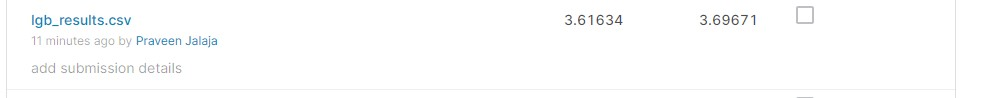

In [8]:
print("Kaggle Score for lighbgm model predictions")
Image("lgb_result_img.jpg")

The Kaggle Score fo the predictions by lightbgm model which made from 280 features is 3.61634. This is an improvment from the baseline score from 3.85 to 3.61634.

### XGBoost

#### Hyperparameter Tuning

In [19]:
## intializing the model
%%time
xgb_model = xgb.XGBRegressor(learning_rate=0.01, n_estimators=100,
                       objective= 'reg:linear',
                       eval_metric ='rmse',
                       silent=True,
                       nthread=8, tree_method='gpu_hist',predictor='gpu_predictor')

## intializing the parameters

xgb_parmas = {
         'num_boost_round': [10, 25, 50], 
         'eta': [0.05, 0.1, 0.3],
         'max_depth': [3, 4, 5, 6,],
          'subsample':[i/10.0 for i in range(5,10)],
         'colsample_bytree':[i/10.0 for i in range(5,10)],
          "min_samples_split": sp_randint(2, 11),
         "min_samples_leaf": sp_randint(1, 11),
          "min_child_weight": range(1,6,2),
         'gamma':[i/10.0 for i in range(0,5)],
          'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
    }

xgb_folds = StratifiedKFold(n_splits=9, random_state=42).split(X_train,outliers.values)

## Randomized search for hyperparameter tuning
random_search_xgb = RandomizedSearchCV(xgb_model,
                                   param_distributions=xgb_parmas,
                                   cv=xgb_folds,
                                   n_jobs=-1, n_iter=30,
                                   verbose=3)

## fitting random search model to find the hyperparameters

random_search_xgb.fit(X_train, y_train)

Fitting 9 folds for each of 30 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 12.6min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fce77c6dc50>,
                   error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          eval_metric='rmse', gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.01, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_...
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fce778bd0b8>,
                                        'min_samples_split': <scipy.stats._dis

In [22]:
## printing the best parameters got from the xgboost method.
best_xgb_params= random_search_xgb.best_params_
best_xgb_params

{'colsample_bytree': 0.9,
 'eta': 0.3,
 'gamma': 0.4,
 'max_depth': 6,
 'min_child_weight': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'num_boost_round': 25,
 'reg_alpha': 1e-05,
 'subsample': 0.9}

In [34]:
## defining essential parametes 
best_xgb_params['learning_rate'] = 0.01
best_xgb_params['objective'] = 'reg:linear'
best_xgb_params['eval_metric'] = 'rmse'
best_xgb_params['silent'] = True
best_xgb_params['tree_method'] = 'gpu_hist'
best_xgb_params['predictor'] = 'gpu_predictor'

In [40]:
best_xgb_params

{'colsample_bytree': 0.9,
 'eta': 0.3,
 'eval_metric': 'rmse',
 'gamma': 0.4,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'num_boost_round': 25,
 'objective': 'reg:linear',
 'reg_alpha': 1e-05,
 'silent': True,
 'subsample': 0.9,
 'tree_method': 'gpu_hist'}

In [109]:
def Xgb_prediction_with_best_parameters(best_params, n_splits, X_train, y_train, 
                                    test, outliers, num_round = 10000):
  ''' This function is function to train and predcit target value with the best parameters 
  on a xgboost model

  parameters:

  reg        : The xgboost Regressor Model to be trained.
  best_params: Dict with the bext parameters for the model.
  n_splits   : number of splits in the Stratified Fold.
  X_train    : Train Data.
  y_train    : target Data.
  test       : test Data.
  outliers   : outlier feature which shows target outliers.
  num_round  : Number of boosting iterations.
  '''

  #prepare fit model with cross-validation
  folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)
  ## intializing the train data 
  pred_y_train = np.zeros(len(X_train))
  ## intializing the prediction test
  pred_y_test = np.zeros(len(test))

  ## fitting the model with folds to validate and predict in batches
  for fold_, (train_idx, val_idx) in enumerate(folds.split(X_train,outliers.values)):
      ## printing the fold number
      print("fold {}".format(fold_))
      ## xgb dataset intializing the data
      train_data = xgb.DMatrix(X_train.iloc[train_idx], label=y_train.iloc[train_idx])
      val_data = xgb.DMatrix(X_train.iloc[val_idx], label=y_train.iloc[val_idx])
      evals = [(train_data, 'train'), (val_data, 'valid')]
      ## intializing the regressor
      reg = xgb.train(best_params, train_data, num_round,evals,
                      verbose_eval=200, early_stopping_rounds = 150)
      ## prediction of the train data
      pred_y_train[val_idx] = reg.predict(xgb.DMatrix(X_train.iloc[val_idx]),
                                         ntree_limit=reg.best_ntree_limit+50)
      
      #prediction of the test data
      pred_y_test = pred_y_test + reg.predict(xgb.DMatrix(test),ntree_limit=reg.best_ntree_limit+50) / folds.n_splits


  return reg, pred_y_train, pred_y_test



In [110]:
### xgb prediction model
xgb_reg, xgb_pred_y_train, xgb_pred_y_test = Xgb_prediction_with_best_parameters(best_params=best_xgb_params,
                                                                                 n_splits=9,X_train= X_train, y_train=y_train,
                                test = test,outliers = outliers, num_round = 10000)

fold 0
[0]	train-rmse:3.95569	valid-rmse:3.8838
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 150 rounds.
[200]	train-rmse:3.59016	valid-rmse:3.64617
[400]	train-rmse:3.5043	valid-rmse:3.6346
[600]	train-rmse:3.4495	valid-rmse:3.63322
[800]	train-rmse:3.40288	valid-rmse:3.63256
Stopping. Best iteration:
[775]	train-rmse:3.40838	valid-rmse:3.63226

fold 1
[0]	train-rmse:3.93273	valid-rmse:4.0662
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 150 rounds.
[200]	train-rmse:3.57925	valid-rmse:3.77213
[400]	train-rmse:3.49529	valid-rmse:3.74639
[600]	train-rmse:3.43829	valid-rmse:3.7407
[800]	train-rmse:3.39315	valid-rmse:3.73817
[1000]	train-rmse:3.3525	valid-rmse:3.73663
[1200]	train-rmse:3.31495	valid-rmse:3.73505
[1400]	train-rmse:3.2793	valid-rmse:3.73373
Stopping. Best iteration:
[1417]	train-rmse:3.27621	valid-rm

In [111]:
print("xgb model RMSE on train {:4f}".format(np.sqrt(mean_squared_error(y_train, xgb_pred_y_train))))

xgb model RMSE on train 3.657368


In [66]:
##saving the model 
pickle.dump(xgb_reg, open(master_path+'xgboost_final.sav', 'wb'))
## saving the predcitions 

np.save(master_path+'xgb_train_pred.npy', xgb_pred_y_train)
np.save(master_path+'xgb_test_pred.npy', xgb_pred_y_test)

In [112]:
results_lgb = pd.DataFrame()
results_lgb['card_id']= test.index
results_lgb['target']= xgb_pred_y_test
results_lgb.to_csv(master_path+'xgb_results.csv', index=False)

Kaggle Score for xgb Model predictions


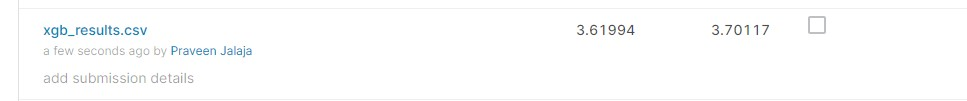

In [7]:
print("Kaggle Score for xgb Model predictions")
Image("xgb_result_img.jpg")

The Kaggle Score fo the predictions by lightbgm model which made from 280 features is 3.61994. This is an improvment from the baseline score from 3.85 to 3.61634 but not from the previous lightbgm model. 

But this model has also produced a good result in predictions.

### Stacking

Stacking is another ensemble technique which can be used to improve the predcitions and the rmse score. 

Stacking can be done in mainly two ways 

1. Simple blending.

2. Stacked using meta Learner.

#### Simple Blending 

Here, The blending is done in these propotions

1. 20% lgb + 80% xgb

2. 50% lgb + 50% xgb

3. 80% lgb + 20% xgb

In [69]:
#loading predcitions of the trained lgb and xgb models
xgb_train_pred = np.load(master_path+'xgb_train_pred.npy')
xgb_test_pred = np.load(master_path+'xgb_test_pred.npy')
lgb_train_pred = np.load(master_path+'lgb_train_pred.npy')
lgb_test_pred = np.load(master_path+'lgb_test_pred.npy')

In [70]:
### 20% lgb + 80% xgb

blend_1_train = 0.2*lgb_train_pred + 0.8*xgb_train_pred

print("20% lgb + 80% xgb RMSE on train {:4f}".format(np.sqrt(mean_squared_error(y_train, blend_1_train))))

20% lgb + 80% xgb RMSE on train 3.654477


In [73]:

blend_2_train = 0.5*lgb_train_pred + 0.5*xgb_train_pred

print("50% lgb + 50% xgb RMSE on train {:4f}".format(np.sqrt(mean_squared_error(y_train, blend_2_train))))

50% lgb + 50% xgb RMSE on train 3.652636


In [74]:

blend_3_train = 0.8*lgb_train_pred + 0.2*xgb_train_pred

print("80% lgb + 20% xgb RMSE on train {:4f}".format(np.sqrt(mean_squared_error(y_train, blend_3_train))))

80% lgb + 20% xgb RMSE on train 3.652610


80% lgb model predcitions + 20% xgb model predcitions seems to be better predictions of the three predictions. So, we will use this blend propotions as the propotions for the test data.

In [76]:
## test Data
blend_3_test = 0.8*lgb_test_pred + 0.2*xgb_test_pred

In [77]:
results_blend = pd.DataFrame()
results_blend['card_id']= test.index
results_blend['target']= blend_3_test
results_blend.to_csv(master_path+'blend_results.csv', index=False)

Kaggle Score For Stacked blending predictions:


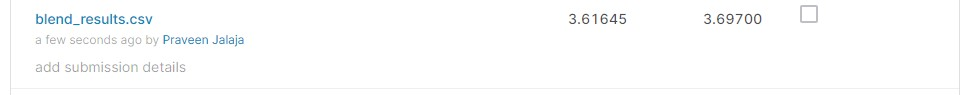

In [9]:
print("Kaggle Score For Stacked blending predictions:")
Image("blend_result_img.jpg")

The simpled blending of results give the kaggle score of 3.61645. which is better the xgboot model predictions but still requires improvement in the score. 


As, of now the lightbgm model has better prediction results than other models.

#### Stacking with meta Learner


Stacking with meta learner can be another ensemble method which can be used for building model on top of the predictions.

For meta learner, usually ridge regression model is preffered. 

First, by tuning the hyperparameters we will get a better predictions with best model

##### hyperparameter tuning

In [84]:
## definfing the data
meta_train = np.vstack([xgb_train_pred, lgb_train_pred]).transpose()
meta_test = np.vstack([xgb_test_pred, lgb_test_pred]).transpose()

In [85]:
## intializing the ridge regressor
ridge_reg = Ridge()
## defining hyperparameters
stack_params = {'alpha': np.array([1,0.1,0.01,0.001,0.0001,0])}

grid_search_stack = GridSearchCV(ridge_reg,param_grid= stack_params,
                                 n_jobs = -1, verbose = 3)


grid_search_stack.fit(meta_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.1s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [86]:
## best alpha for ridge regression
grid_search_stack.best_params_

{'alpha': 1.0}

In [96]:
#prepare fit model with cross-validation
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
## intializing the train data 
stack_pred_y_train = np.zeros(len(meta_train))
## intializing the prediction test
stack_pred_y_test = np.zeros(len(meta_test))

## fitting the model with folds to validate and predict in batches
for fold_, (train_idx, val_idx) in enumerate(folds.split(meta_train,outliers.values)):
    ## intializing the data
    train_data, train_y = meta_train[train_idx], y_train.iloc[train_idx].values
    val_data, val_y = meta_train[val_idx], y_train.iloc[val_idx].values
    ## intializing the regressor
    rdige_reg = Ridge(alpha = 1.0)
    rdige_reg.fit(train_data,train_y)
    ## prediction on train data
    stack_pred_y_train[val_idx] = rdige_reg.predict(val_data)
    
    #prediction of the test data
    stack_pred_y_test = stack_pred_y_test + rdige_reg.predict(meta_test) / folds.n_splits

In [97]:
print("stacked model RMSE on train {:4f}".format(np.sqrt(mean_squared_error(y_train, stack_pred_y_train))))

stacked model RMSE on train 3.651791


In [98]:
##saving the model 
pickle.dump(rdige_reg, open(master_path+'stacked_final.sav', 'wb'))
## saving the predcitions 

np.save(master_path+'xgb_train_pred.npy', stack_pred_y_train)
np.save(master_path+'xgb_test_pred.npy', stack_pred_y_test)

In [99]:
results_stack = pd.DataFrame()
results_stack['card_id']= test.index
results_stack['target']= stack_pred_y_test
results_stack.to_csv(master_path+'stack_results.csv', index=False)

Kaggle Score for xgb Model predictions


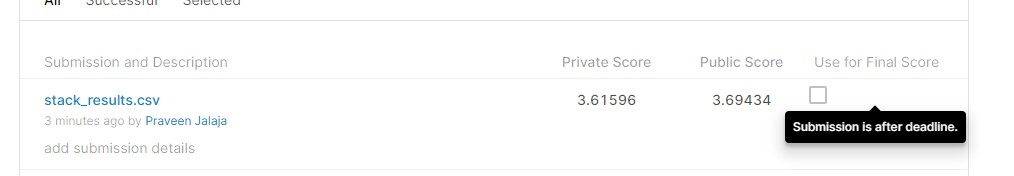

In [5]:

print("Kaggle Score for xgb Model predictions")
Image("stack_result_img.jpg")

### Conclusion

The Final Results of the models are given below.

In [103]:
x = PrettyTable()
x.hrules = prettytable.ALL

x.add_column('Model',['LightBGM with 280 features','XGboost with 280 features',
                      "20% LightBGM + 80% XGboost Blend","Stacked Model with meta learner"])
x.add_column('Private Score', ['3.61634','3.61994','3.61645','3.61596'])
x.add_column('Public Score', ['3.69671','3.70117','3.69700','3.69434'])

print(x)

+----------------------------------+---------------+--------------+
|              Model               | Private Score | Public Score |
+----------------------------------+---------------+--------------+
|    LightBGM with 280 features    |    3.61634    |   3.69671    |
+----------------------------------+---------------+--------------+
|    XGboost with 280 features     |    3.61994    |   3.70117    |
+----------------------------------+---------------+--------------+
| 20% LightBGM + 80% XGboost Blend |    3.61645    |   3.69700    |
+----------------------------------+---------------+--------------+
| Stacked Model with meta learner  |    3.61596    |   3.69434    |
+----------------------------------+---------------+--------------+


In the end, with 280 engineered features GBDT models with lightbgm and xgboost are trained. 

The stacked model with Ridge meta learner has given low RMSE socre of 3.61596.


This is the lowest score we got for predictions of loyalty Score.